/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'kspsap_flux_lag', 'kspsap_flux_sml', 'sap_flux', 'kspsap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'kspsap_flux_lag', 'kspsap_flux_sml', 'sap_flux', 'kspsap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collec

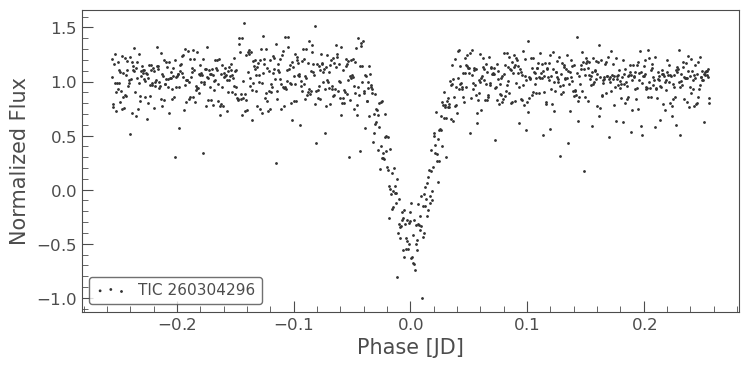

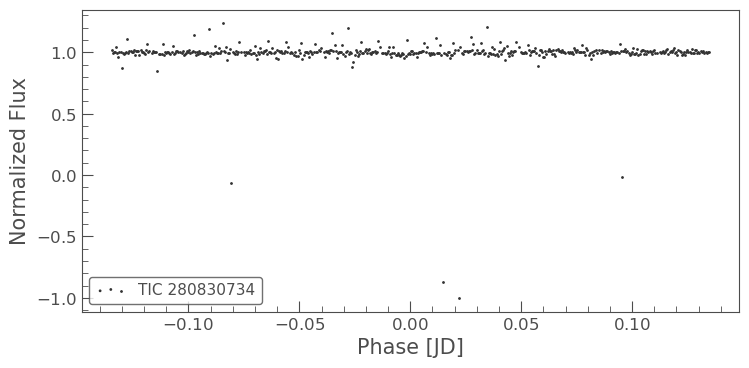

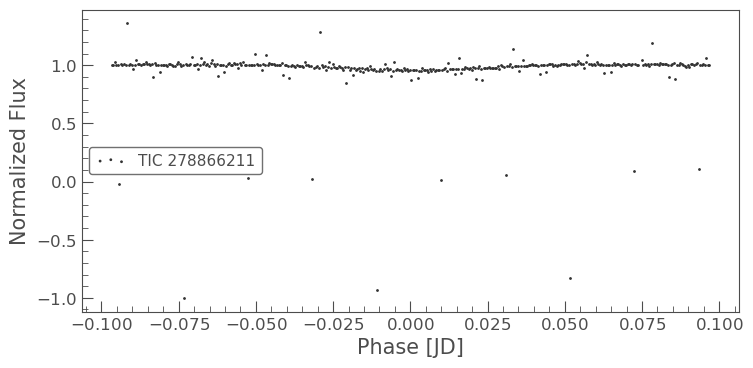

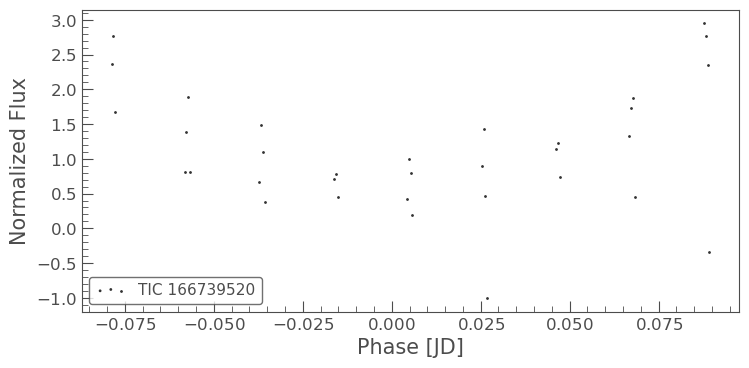

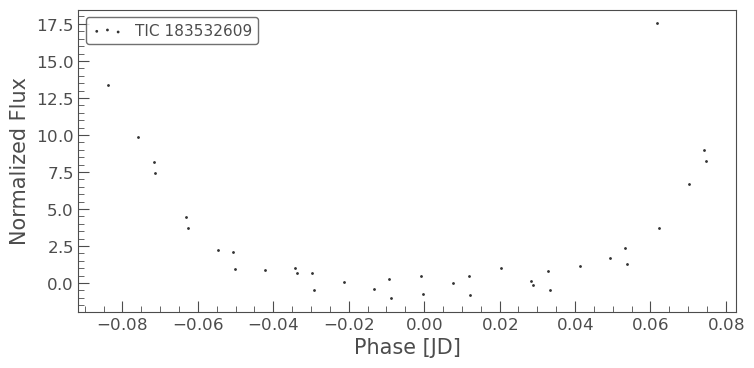

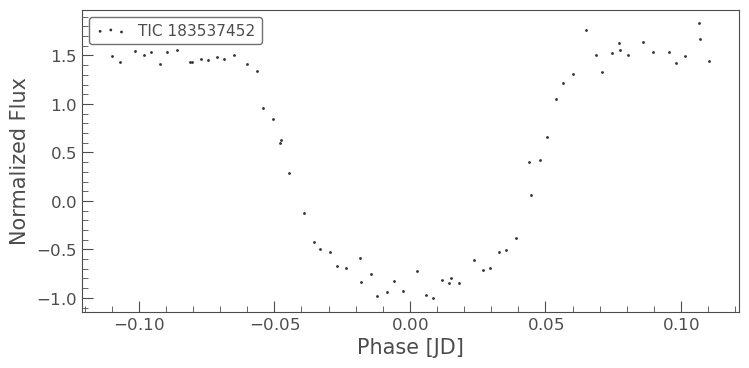

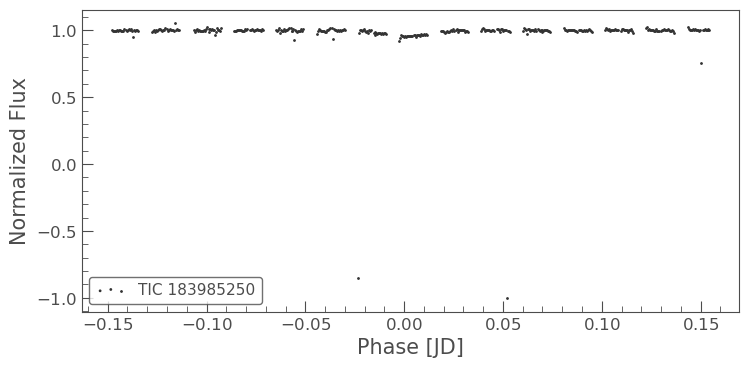

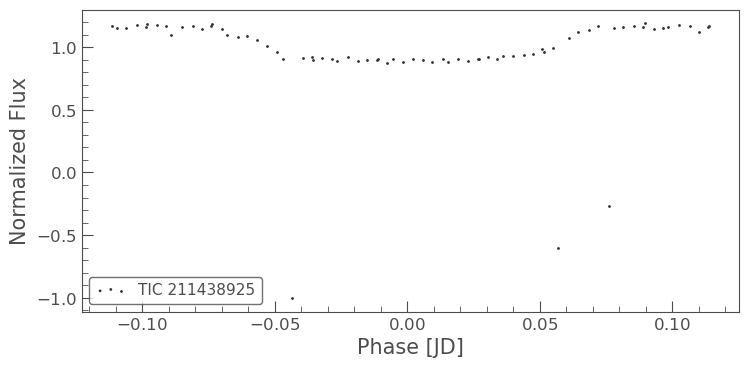

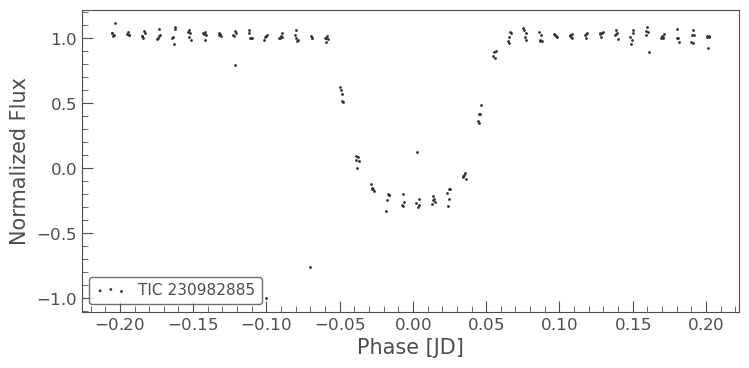

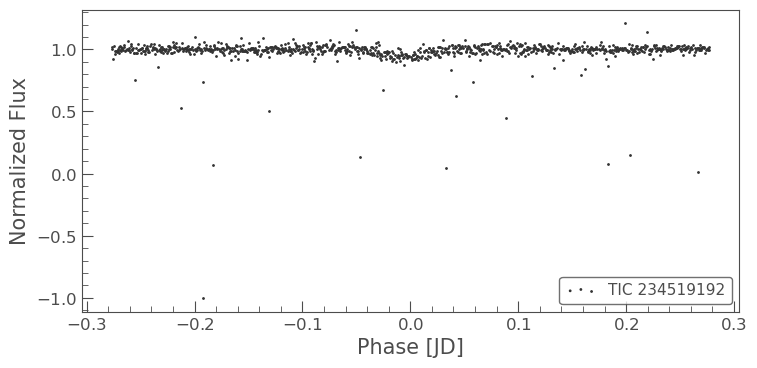

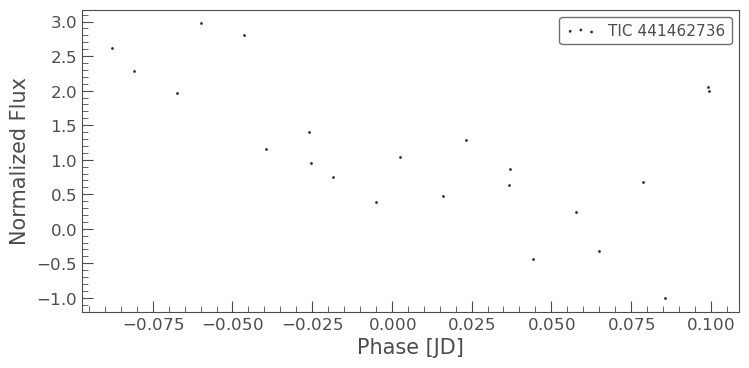

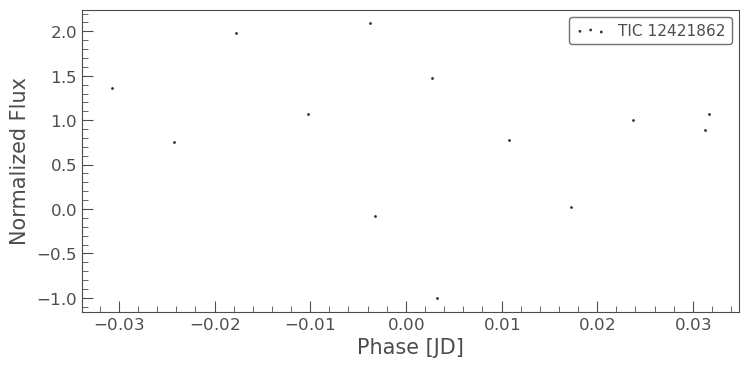

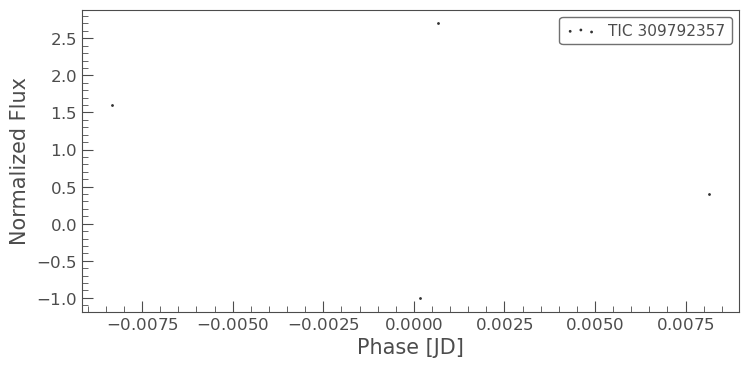

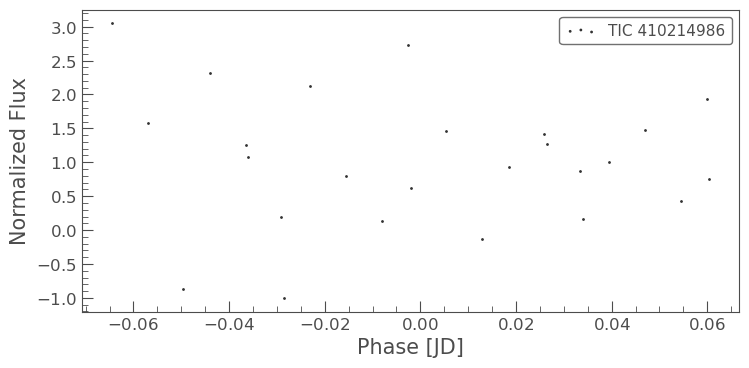

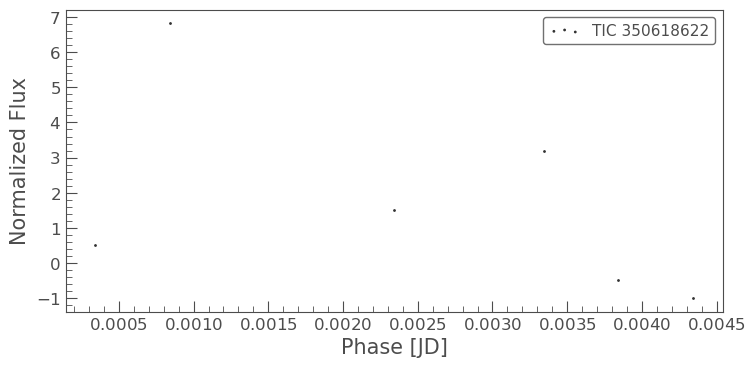

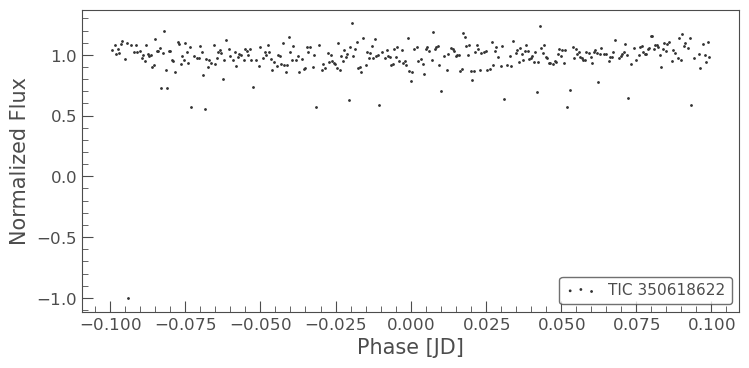

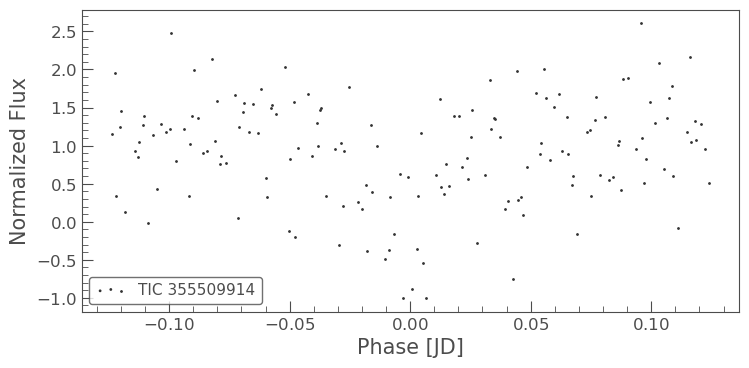

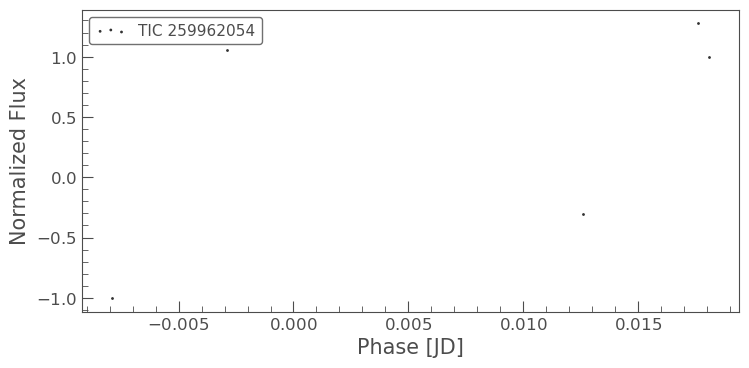

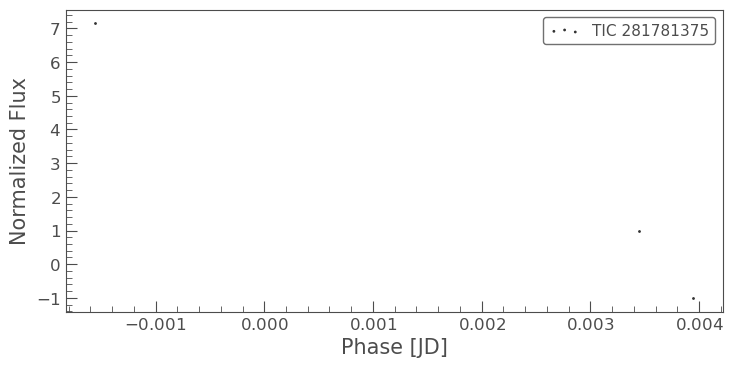

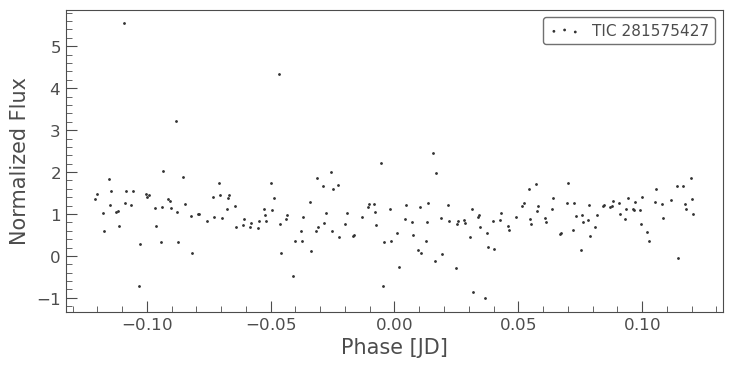

In [3]:
#METHOD 1: using the correction tutorial from https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-machine-learning-preprocessing.html
#catches errors if they do occur when processing the lightcurve

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

for x in range(100, 120):
    TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
    period = float(rows[x][fields.index("Period (days)")])
    t0 = float(rows[x][fields.index("Epoch (BJD)")])
    duration_hours = float(rows[x][fields.index("Duration (hours)")])
    
    try:
        search_result = lk.search_lightcurve(TOI_name, exptime=1800) #searching for curves with a given cadence (i.e. 30 mins)
        search_result = search_result[1:] #to get rid of the DIAMANTE author
        if(len(search_result) == 0):
            search_result = lk.search_lightcurve(TOI_name, exptime=120) #if no curves with the given cadence exist, pick a different cadence

        lcs = search_result.download_all() #downloading all the curves with that cadence
        lc_raw = lcs.stitch() #stitching the curves together

        lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4) #removes data points if they are sigma standard deviations from the median
        #sigma_upper is for the number of standard deviations above the median to clip

        temp_fold = lc_clean.fold(period, epoch_time=(t0-2457000)) #doing an initial fold of the lightcurve
        #epoch_time is used in units of BJD, not JD, so we subtract 2457000 from the initial epoch time
        fractional_duration = (duration_hours / 24.0) / period #calculates the fraction of the period that is taken up by the actual transit of the planet
        phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5) #a mask is an array with True during transits and False elsewhere
        #creates an np array that has True if the value of the phase of the curve is within 1.5 of the fractional duration of the transit
        #because 0 is the very middle of the planet's transit?? so we are getting an ample window on either side of the transit
        transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])
        #temp_fold.time_original.value[phase_mask]: shorter array with only the length of the number of "True"s in the phase_mask
        #transit_mask: True if the time value from the original unfolded array is a time masked by the phase_mask

        lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask) #flattens the lightcurve; does not remove data that is masked by the transit mask
        lc_fold = lc_flat.fold(period, epoch_time=(t0-2457000)) #folds the new, flattened, cleaner lightcurve

        lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1 #binning: uses interpolation to create a new point every 0.005 time units; returns a curve made of those new points
        #normalize the flux so the curve starts at 1 and dips down
        #subtract 1 so the curve starts at 0 and dips into the negative numbers
        #NOTE: the .normalize() method divides all flux values by the median flux 
        lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1 #divide by the lowest point on the curve so that the curve starts at 0 and dips down to -1
        # multiply by 2 and then add 1 so the curve goes from a flux of 1 to -1

        phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration) 
        #create a phase mask that only takes data inside of 4 times the fractional duration of the transit
        lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
        #again, this curve starts at 1 and dips down

        lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #same process as for the lc_global curve
        lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
        #end result: a curve that goes from a flux of 1 to a flux of -1

        lc_local.scatter(); #plot a scatterplot of the final data
    except:
        print("Error in processing", TOI_name)

/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column 

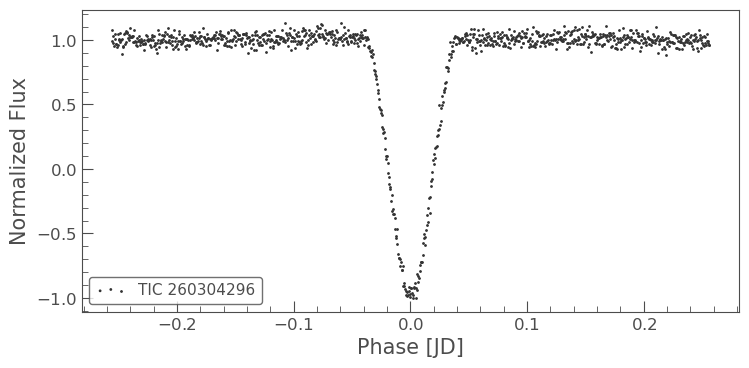

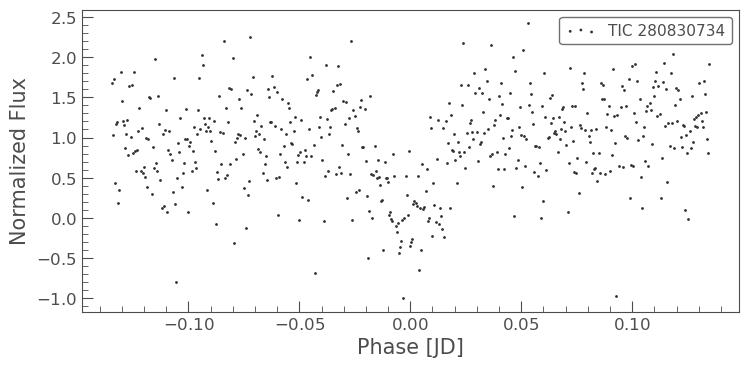

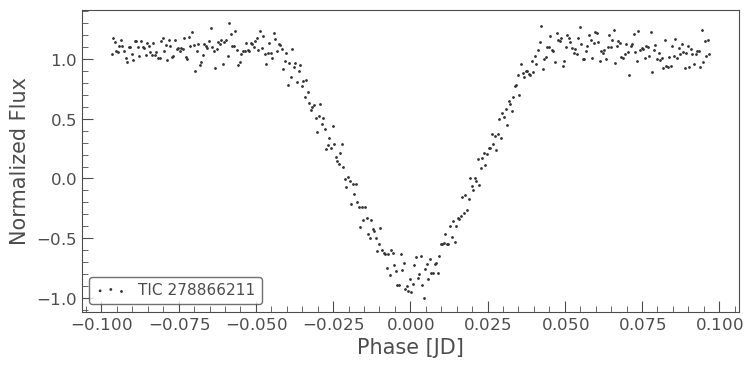

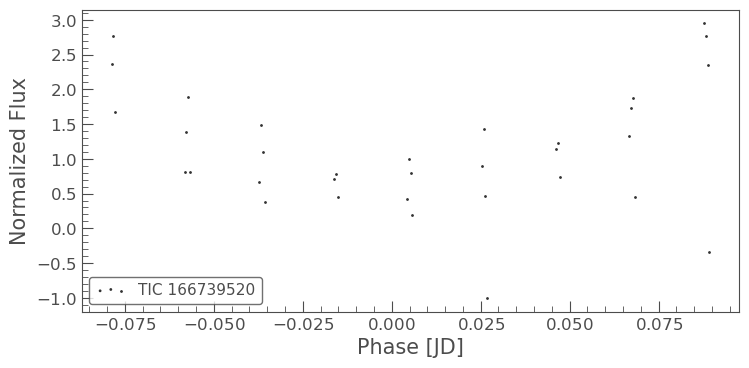

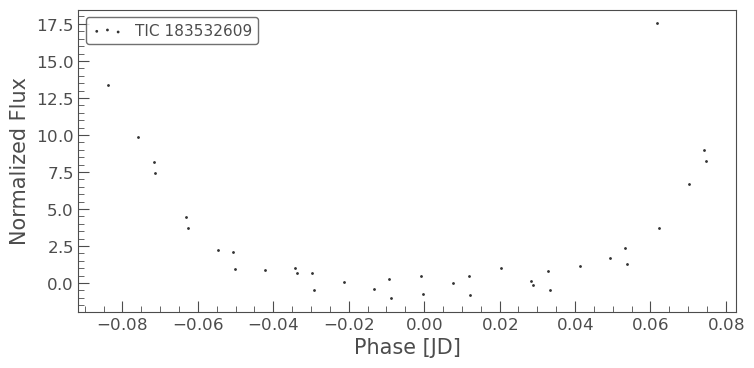

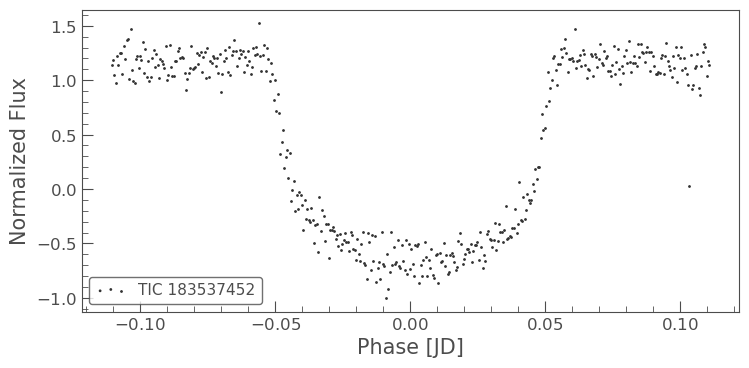

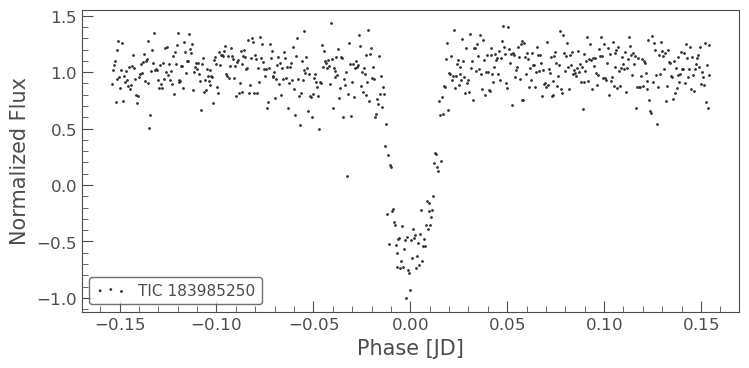

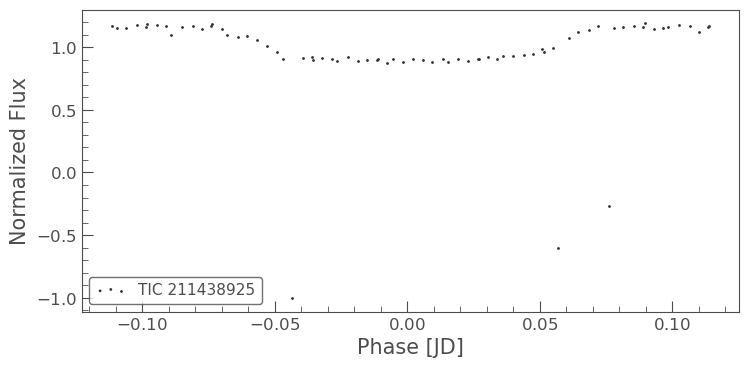

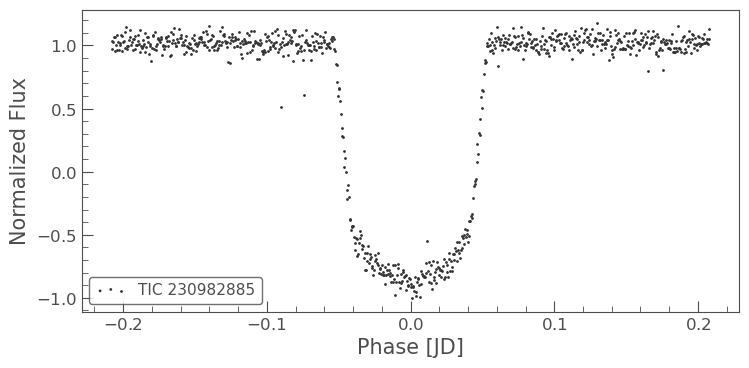

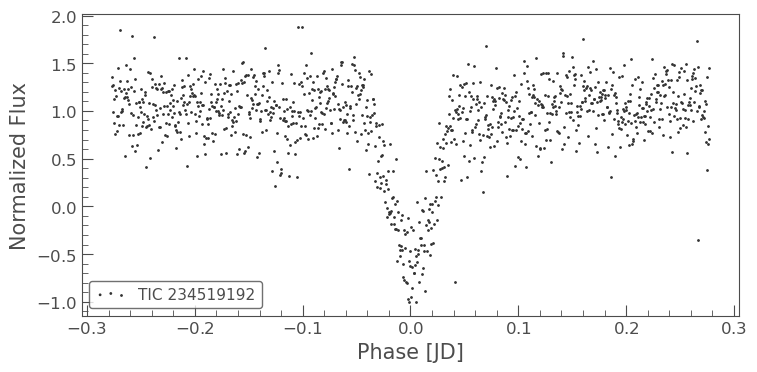

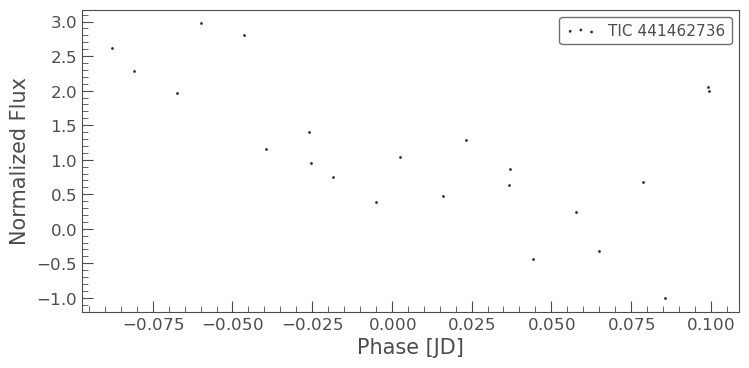

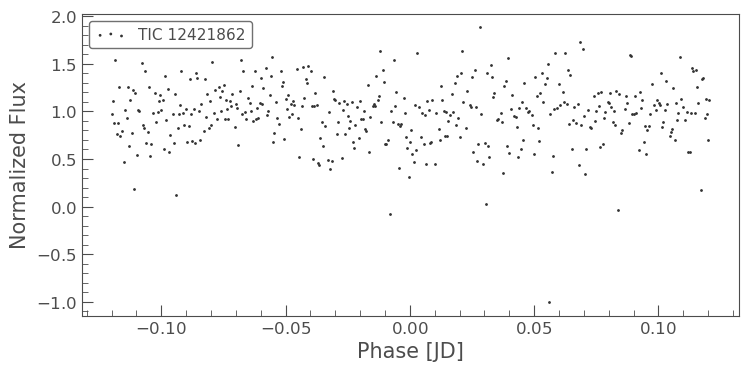

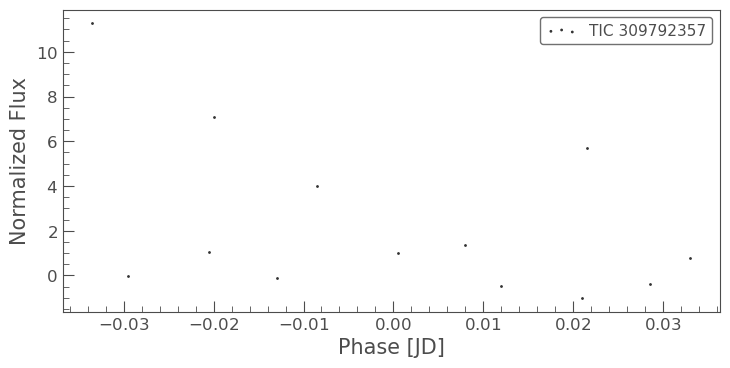

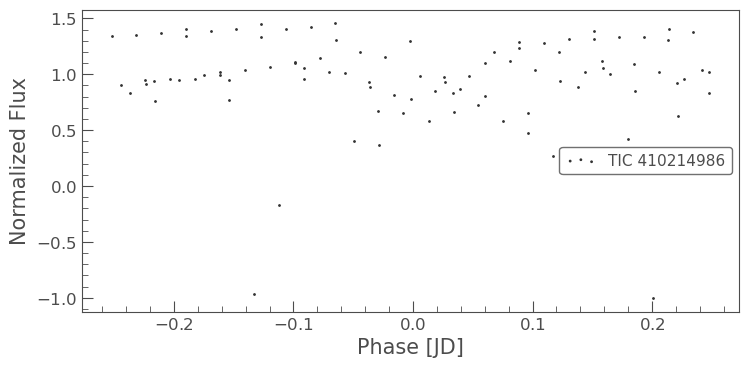

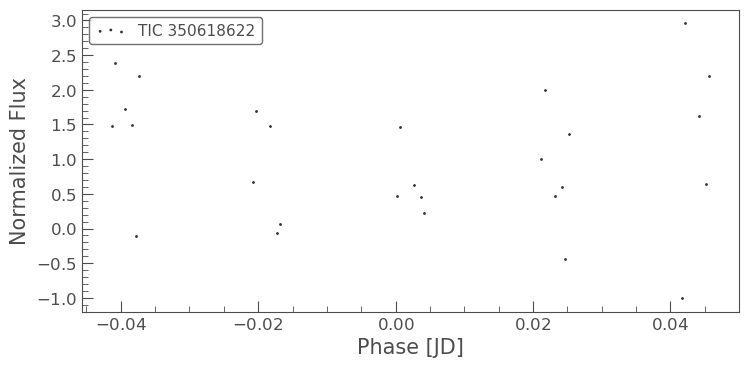

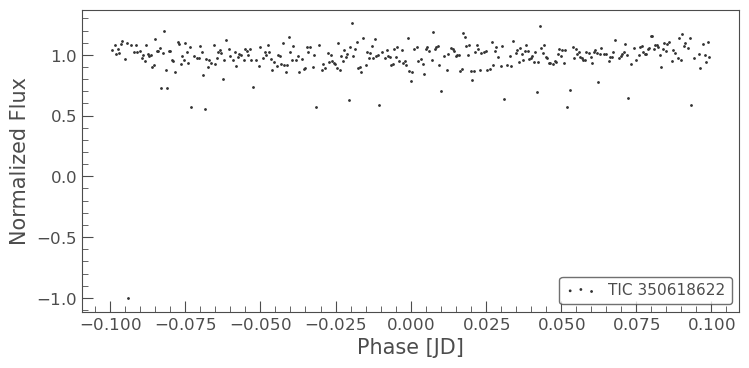

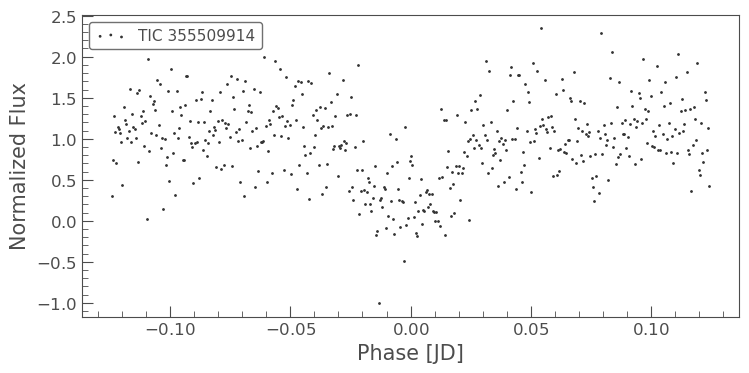

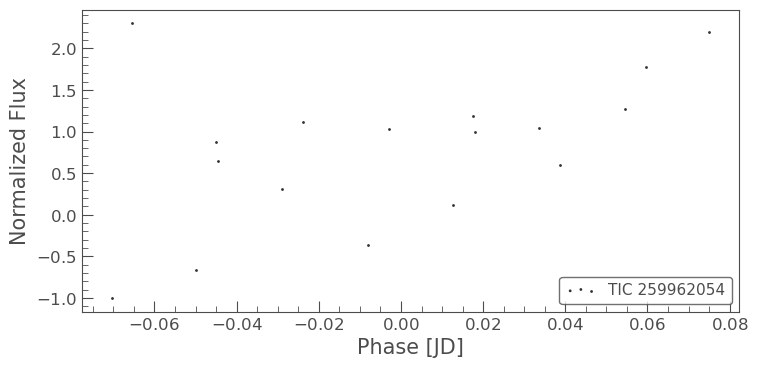

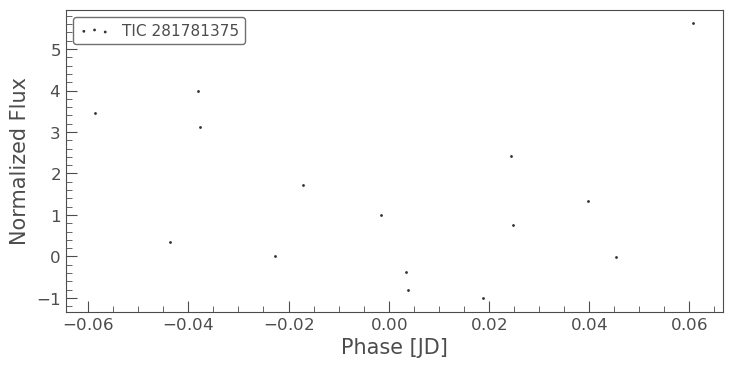

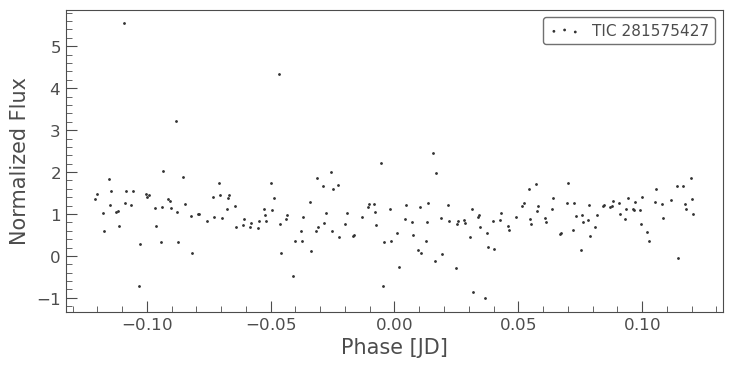

In [4]:
#METHOD 2: refining method 1
#if the period is short, choose a shorter cadence (2 mins, not 30 mins) for more data
#if the duration of the transit is short, take a larger window to see

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

for x in range(100, 120):
    TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
    period = float(rows[x][fields.index("Period (days)")])
    t0 = float(rows[x][fields.index("Epoch (BJD)")])
    duration_hours = float(rows[x][fields.index("Duration (hours)")])
    
    try:
        if(duration_hours < 3.0): #if the period is short, choose a shorter cadence for more data
            search_result = lk.search_lightcurve(TOI_name, exptime=120)
        else:  
            search_result = lk.search_lightcurve(TOI_name, exptime=1800) #searching for curves with a given cadence (i.e. 30 mins)
            search_result = search_result[1:] #to get rid of the DIAMANTE author
            if(len(search_result) == 0):
                search_result = lk.search_lightcurve(TOI_name, exptime=120) #if no curves with the given cadence exist, pick a different cadence

        lcs = search_result.download_all() #downloading all the curves with that cadence
        lc_raw = lcs.stitch() #stitching the curves together

        lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4) #removes data points if they are sigma standard deviations from the median
        #sigma_upper is for the number of standard deviations above the median to clip

        temp_fold = lc_clean.fold(period, epoch_time=(t0-2457000)) #doing an initial fold of the lightcurve
        #epoch_time is used in units of BJD, not JD, so we subtract 2457000 from the initial epoch time
        fractional_duration = (duration_hours / 24.0) / period #calculates the fraction of the period that is taken up by the actual transit of the planet
        phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5) #a mask is an array with True during transits and False elsewhere
        #creates an np array that has True if the value of the phase of the curve is within 1.5 of the fractional duration of the transit
        #because 0 is the very middle of the planet's transit?? so we are getting an ample window on either side of the transit
        transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])
        #temp_fold.time_original.value[phase_mask]: shorter array with only the length of the number of "True"s in the phase_mask
        #transit_mask: True if the time value from the original unfolded array is a time masked by the phase_mask

        lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask) #flattens the lightcurve; does not remove data that is masked by the transit mask
        lc_fold = lc_flat.fold(period, epoch_time=(t0-2457000)) #folds the new, flattened, cleaner lightcurve

        lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1 #binning: uses interpolation to create a new point every 0.005 time units; returns a curve made of those new points
        #normalize the flux so the curve starts at 1 and dips down
        #subtract 1 so the curve starts at 0 and dips into the negative numbers
        #NOTE: the .normalize() method divides all flux values by the median flux 
        lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1 #divide by the lowest point on the curve so that the curve starts at 0 and dips down to -1
        # multiply by 2 and then add 1 so the curve goes from a flux of 1 to -1

        if(fractional_duration < 0.02): #if the duration of the transit is short, take a larger window to see
            phase_mask = (lc_fold.phase > -15*fractional_duration) & (lc_fold.phase < 15.0*fractional_duration) 
        else:
            phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration) 
            #create a phase mask that only takes data inside of 4 times the fractional duration of the transit
        lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
        #again, this curve starts at 1 and dips down

        lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #same process as for the lc_global curve
        lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
        #end result: a curve that goes from a flux of 1 to a flux of -1

        lc_local.scatter(); #plot a scatterplot of the final data
    except:
        print("Error in processing", TOI_name)

/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column 

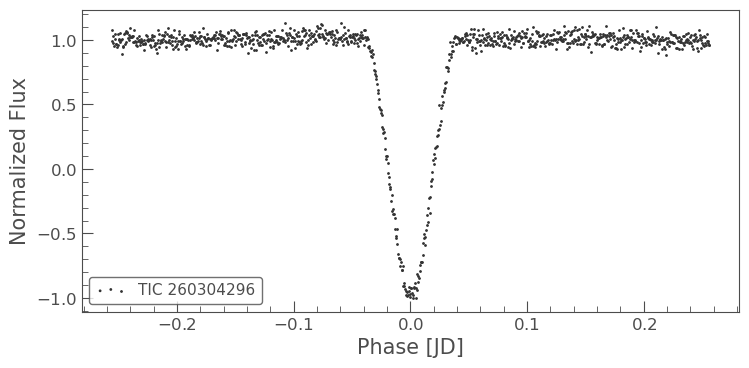

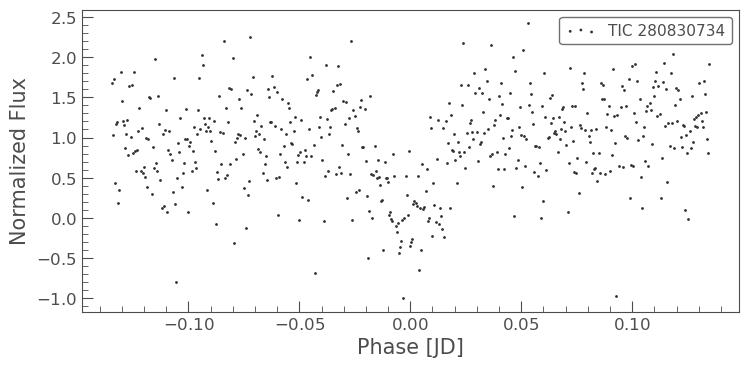

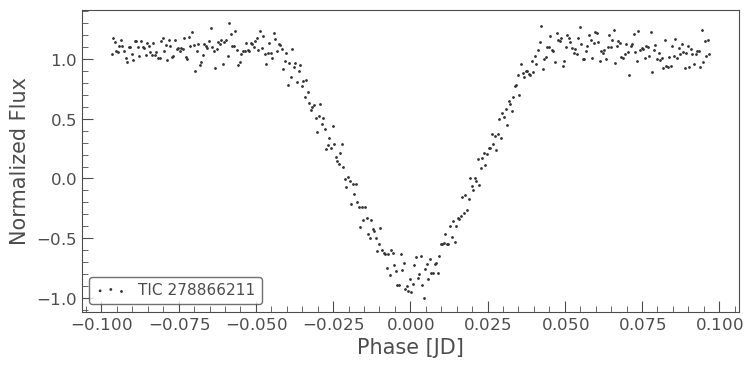

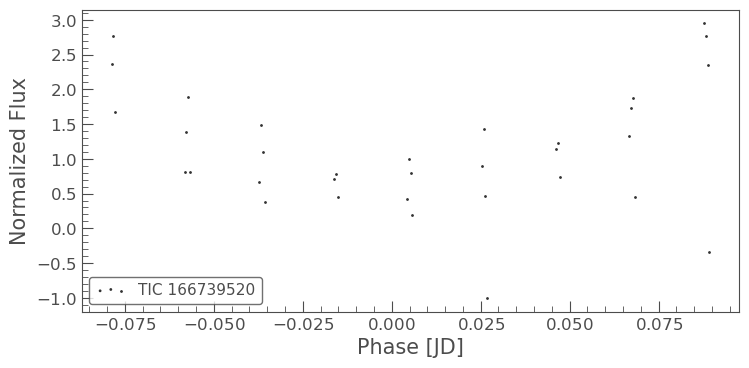

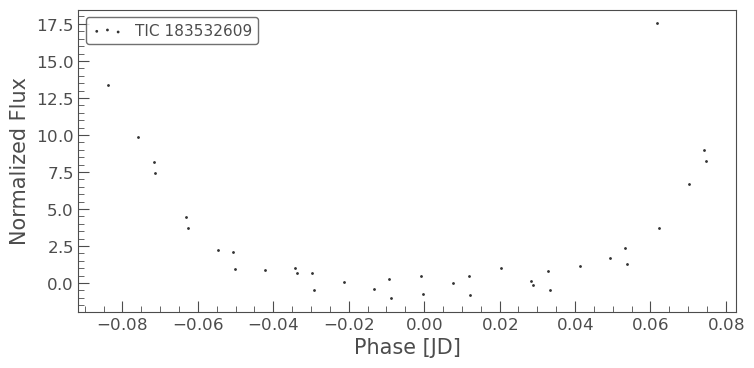

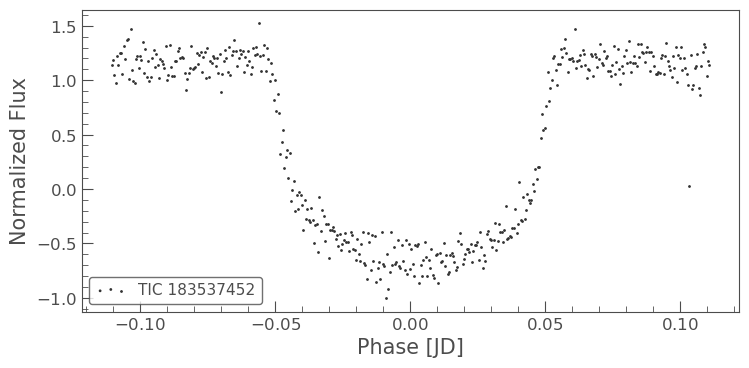

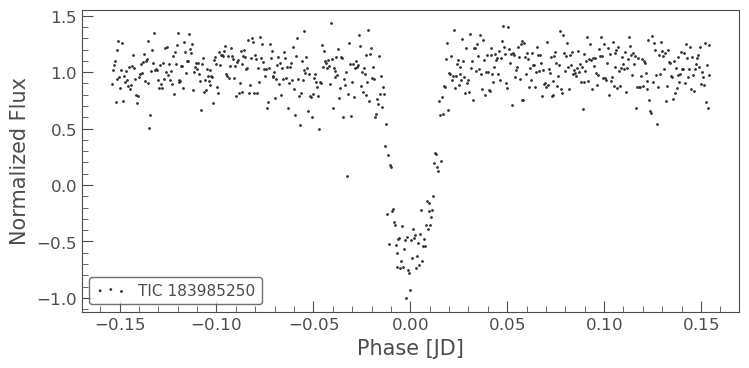

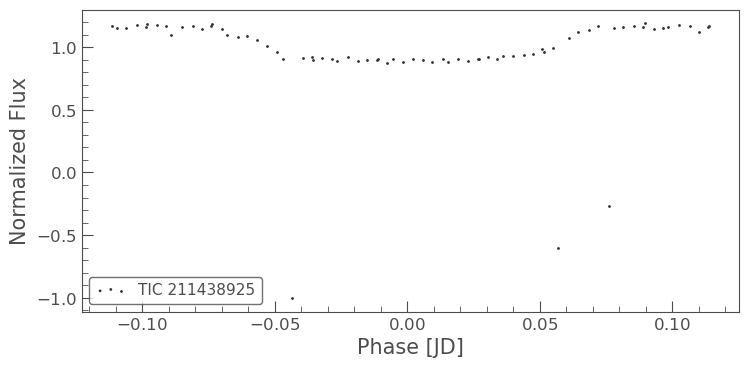

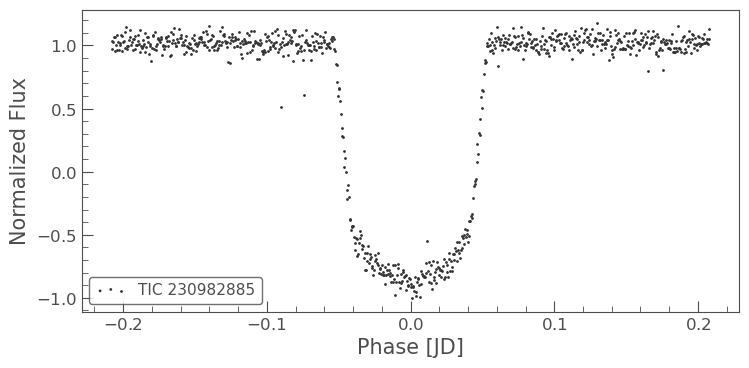

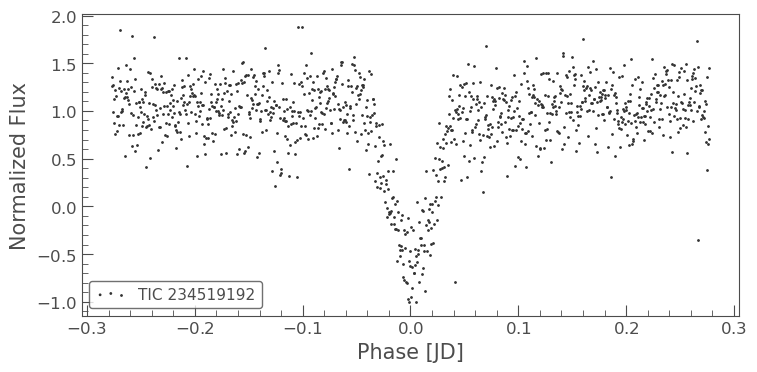

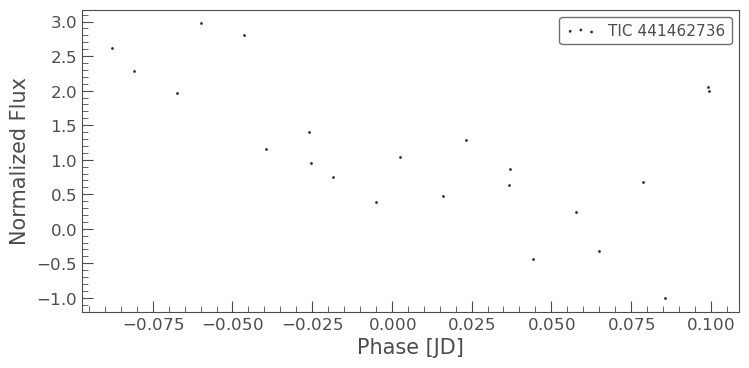

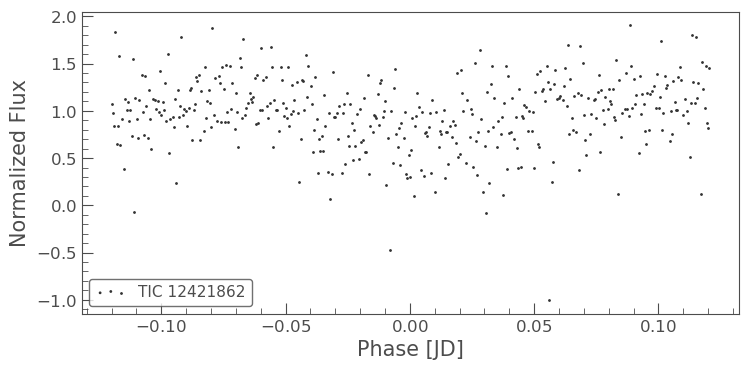

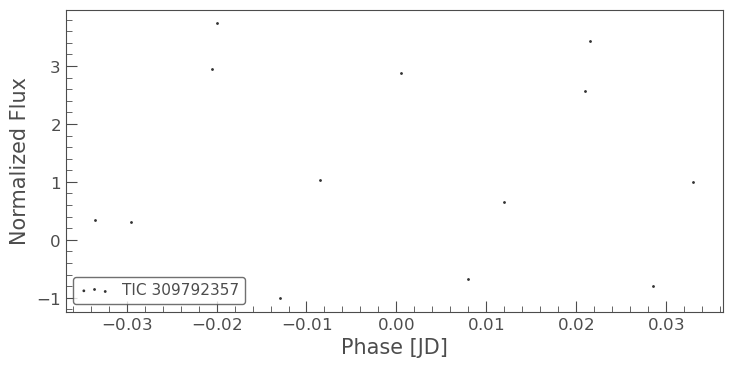

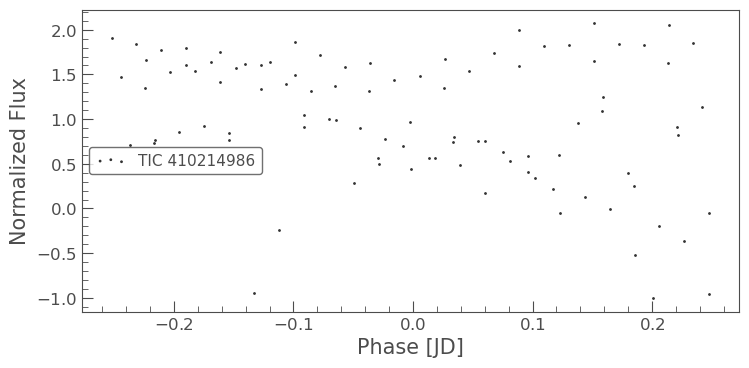

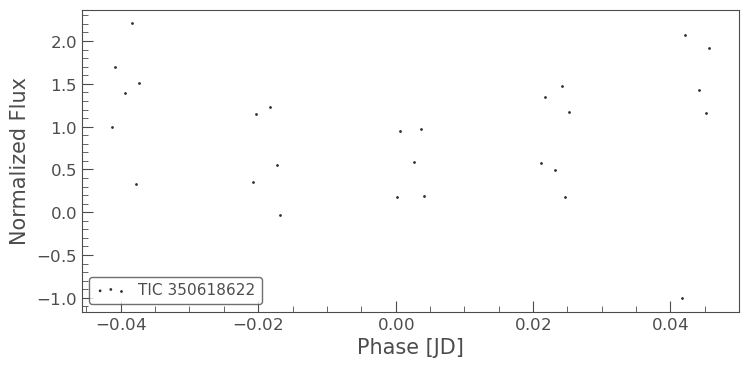

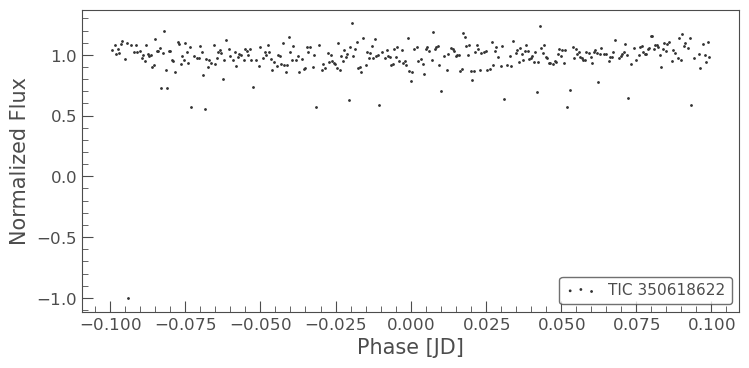

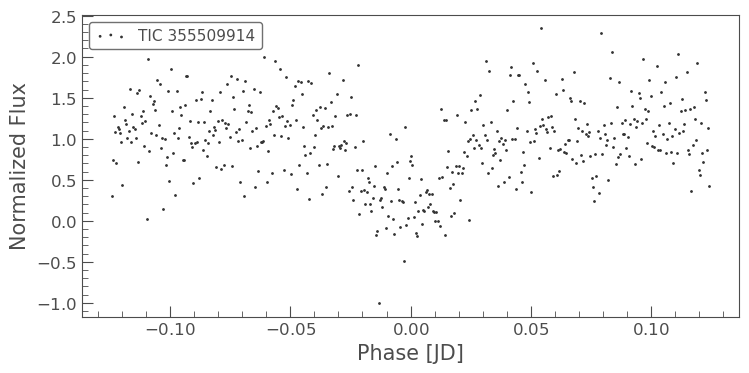

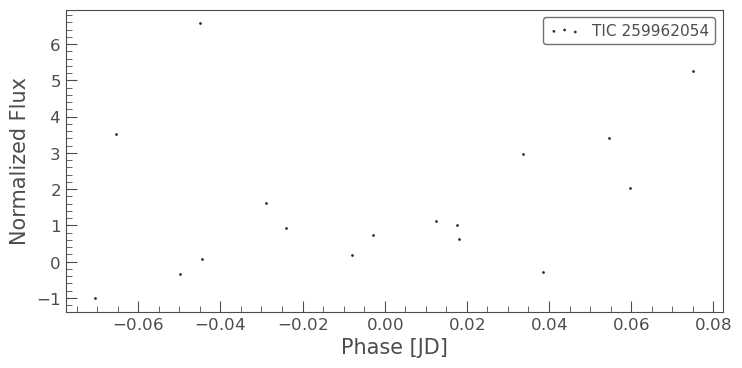

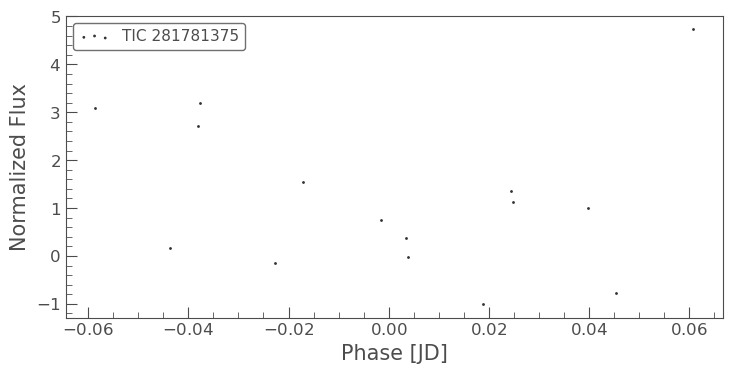

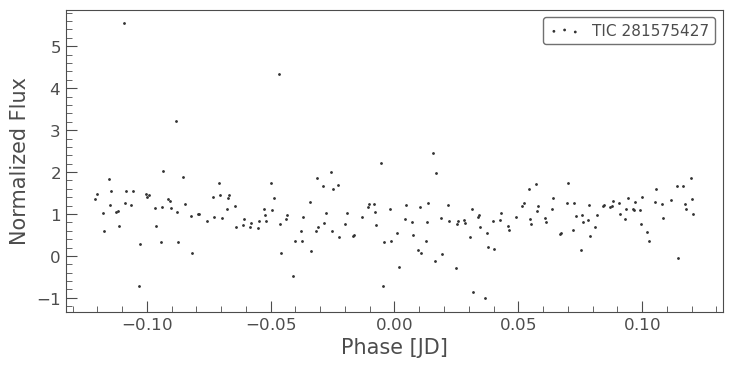

In [5]:
#METHOD 3: refining method 2
#error-catching: double-checking to make sure no NoneType items are in the search result
#if the fractional duration is short, doing a different processing method to avoid cutting out too much data

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

for x in range(100, 120):
    TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
    period = float(rows[x][fields.index("Period (days)")])
    t0 = float(rows[x][fields.index("Epoch (BJD)")])
    duration_hours = float(rows[x][fields.index("Duration (hours)")])
    
    try:
        if(duration_hours < 3.0):
            search_result = lk.search_lightcurve(TOI_name, exptime=120) #if the period is short, choose a shorter cadence for more data
            if(len(search_result) == 0):
                search_result = lk.search_lightcurve(TOI_name, exptime=1800) #if no curves with the given cadence exist, pick a different cadence
                search_result = search_result[1:] #to get rid of the DIAMANTE author
        else:  
            search_result = lk.search_lightcurve(TOI_name, exptime=1800) #searching for curves with a given cadence (i.e. 30 mins)
            search_result = search_result[1:] #to get rid of the DIAMANTE author
            if(len(search_result) == 0):
                search_result = lk.search_lightcurve(TOI_name, exptime=120) #if no curves with the given cadence exist, pick a different cadence

        lcs = search_result.download_all() #downloading all the curves with that cadence
        for item in lcs:
            if(type(item) is None): #double-checking to make sure no NoneType items are in the search result
                del(item)
        
        lc_raw = lcs.stitch() #stitching the curves together

        lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4) #removes data points if they are sigma standard deviations from the median
        #sigma_upper is for the number of standard deviations above the median to clip

        fractional_duration = (duration_hours / 24.0) / period #calculates the fraction of the period that is taken up by the actual transit of the planet

        if(fractional_duration < 0.02): #if the duration of the transit is short, choose a different simplifying method to avoid deleting too much data
            lc_fold = lc_clean.fold(period, epoch_time=(t0-2457000))
            #skipping a lot of the pre-processing
            phase_mask = (lc_fold.phase > -15*fractional_duration) & (lc_fold.phase < 15.0*fractional_duration) 
            #create a phase mask that takes data inside of 15 times the fractional duration of the transit
            lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
            #again, this curve starts at 1 and dips down

            lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #look down: same process as for the lc_global curve
            lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
            #end result: a curve that goes from a flux of 1 to a flux of -1

            lc_local.scatter(); #plot a scatterplot of the final data

        else:
            temp_fold = lc_clean.fold(period, epoch_time=(t0-2457000)) #doing an initial fold of the lightcurve
            #epoch_time is used in units of BJD, not JD, so we subtract 2457000 from the initial epoch time
            phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5) #a mask is an array with True during transits and False elsewhere
            #creates an np array that has True if the value of the phase of the curve is within 1.5 of the fractional duration of the transit
            #because 0 is the very middle of the planet's transit?? so we are getting an ample window on either side of the transit
            transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])
            #temp_fold.time_original.value[phase_mask]: shorter array with only the length of the number of "True"s in the phase_mask
            #transit_mask: True if the time value from the original unfolded array is a time masked by the phase_mask

            lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask) #flattens the lightcurve; does not remove data that is masked by the transit mask
            lc_fold = lc_flat.fold(period, epoch_time=(t0-2457000)) #folds the new, flattened, cleaner lightcurve

            lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1 #binning: uses interpolation to create a new point every 0.005 time units; returns a curve made of those new points
            #normalize the flux so the curve starts at 1 and dips down
            #subtract 1 so the curve starts at 0 and dips into the negative numbers
            #NOTE: the .normalize() method divides all flux values by the median flux 
            lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1 #divide by the lowest point on the curve so that the curve starts at 0 and dips down to -1
            # multiply by 2 and then add 1 so the curve goes from a flux of 1 to -1

            phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration) 
            #create a phase mask that only takes data inside of 4 times the fractional duration of the transit
            lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
            #again, this curve starts at 1 and dips down

            lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #same process as for the lc_global curve
            lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
            #end result: a curve that goes from a flux of 1 to a flux of -1

            lc_local.scatter(); #plot a scatterplot of the final data
    except:
        print("Error in processing", TOI_name)

Error in processing TIC 314375831


/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'kspsap_flux', 'kspsap_flux_sml', 'sap_bkg_err', 'sap_bkg', 'sap_flux', 'kspsap_flux_lag'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'kspsap_flux', 'kspsap_flux_sml', 'sap_bkg_err', 'sap_bkg', 'sap_flux', 'kspsap_flux_lag'}
  warnings.warn(
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(


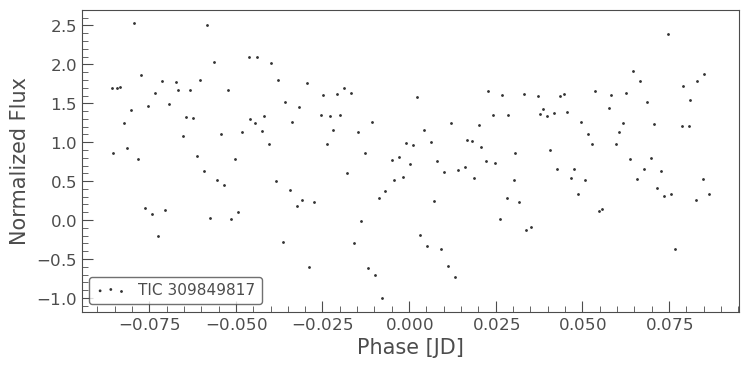

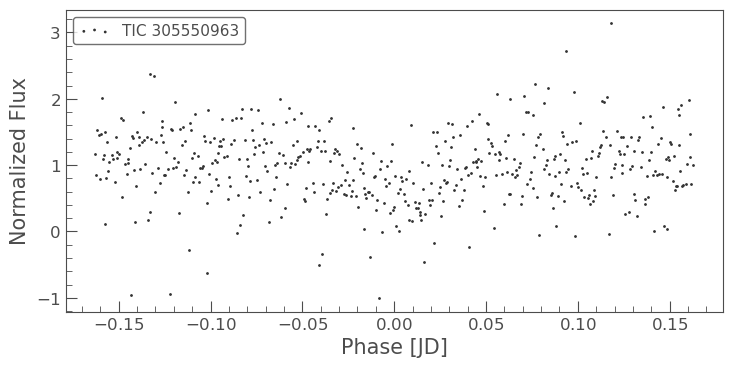

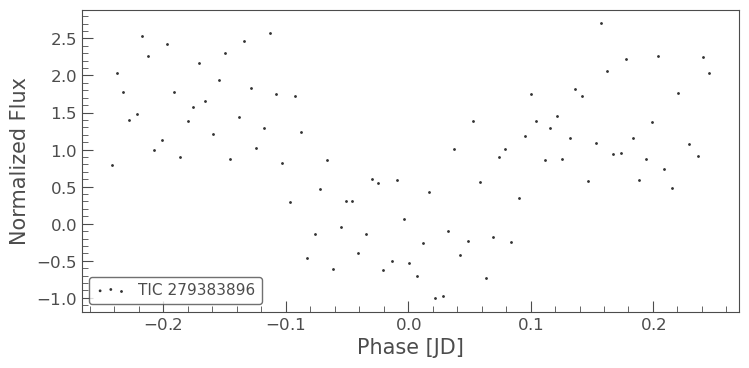

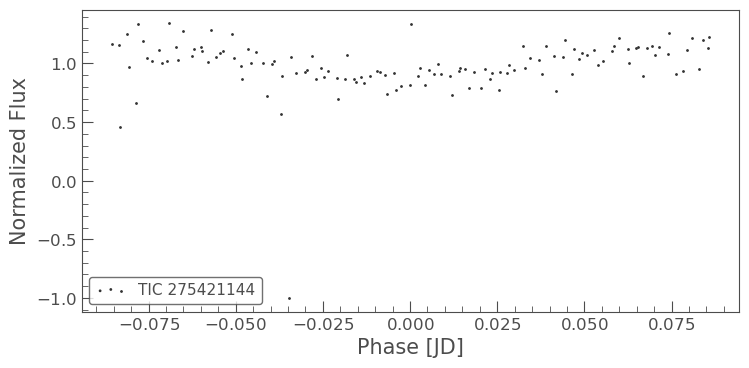

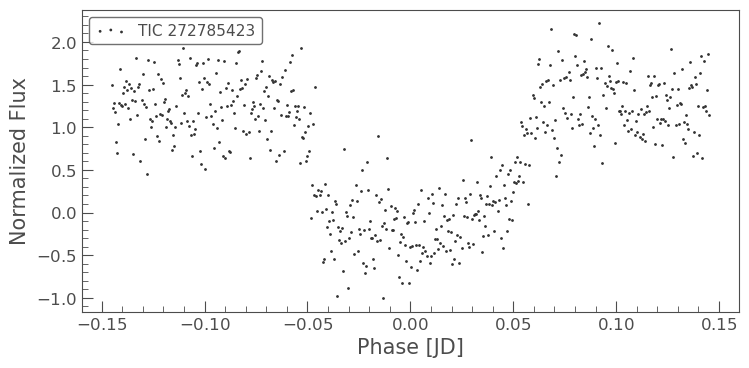

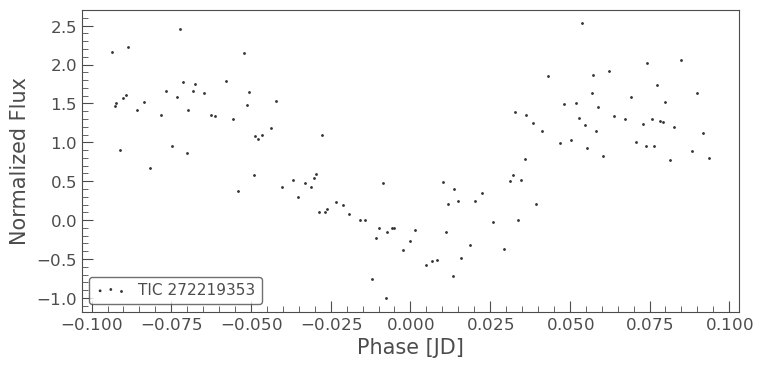

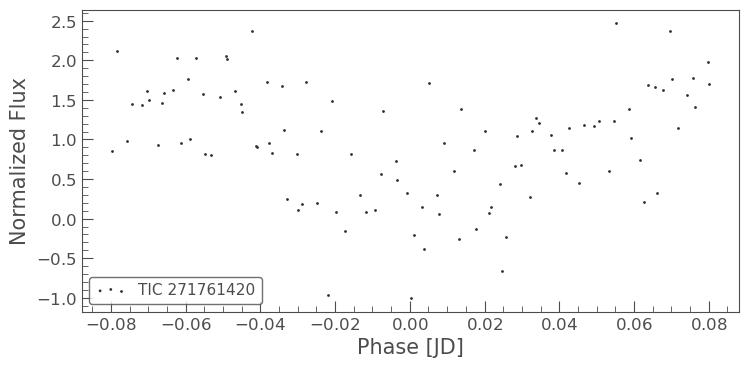

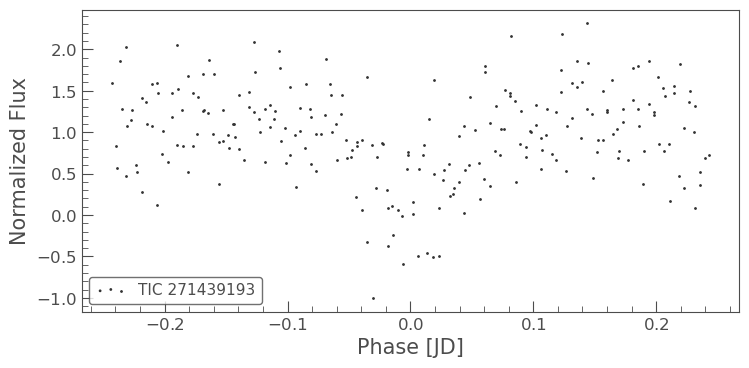

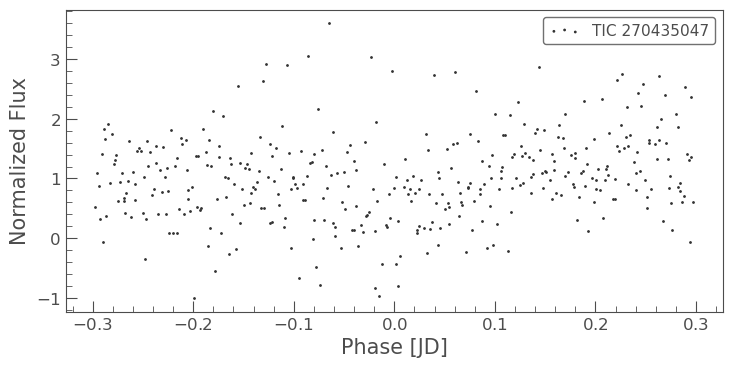

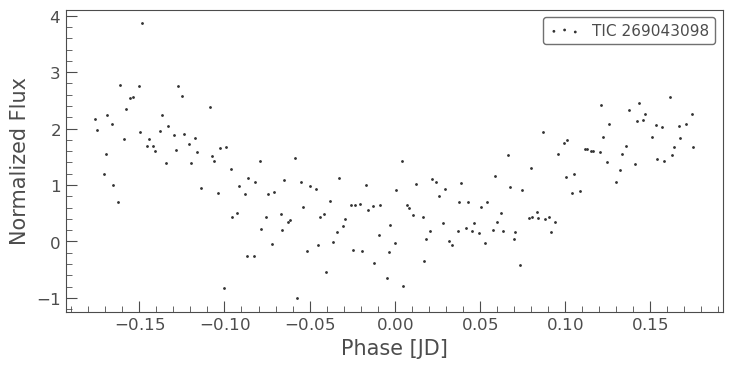

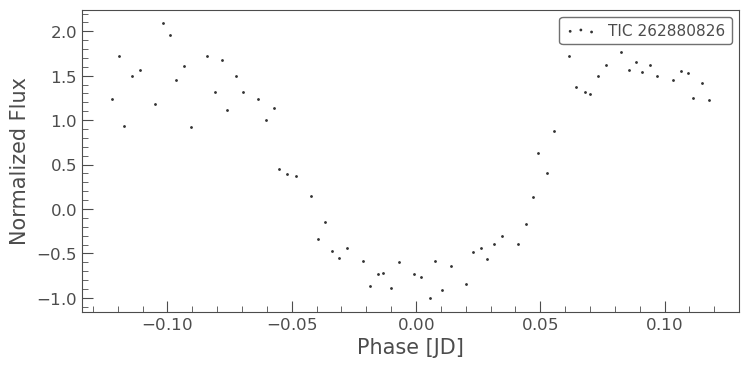

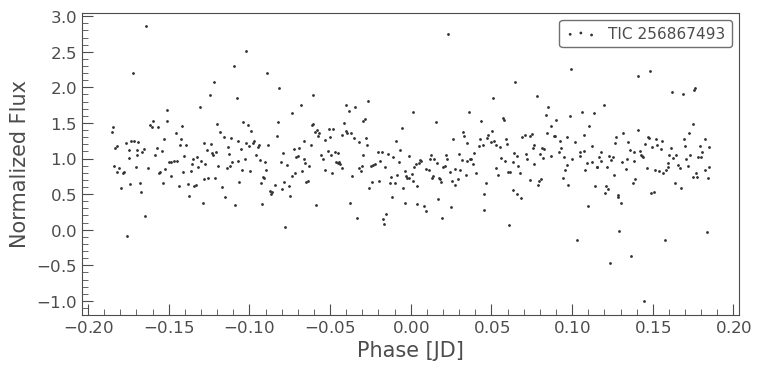

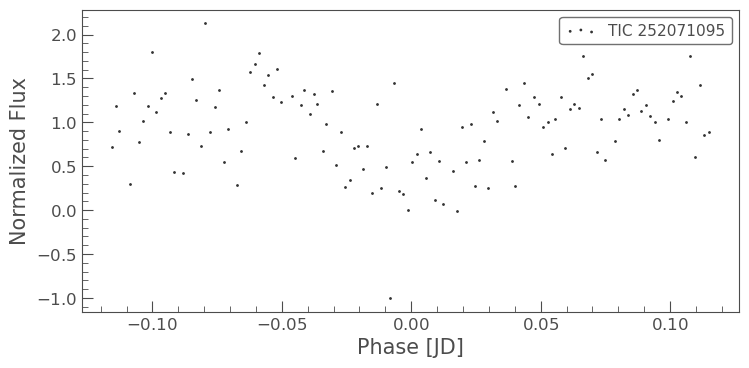

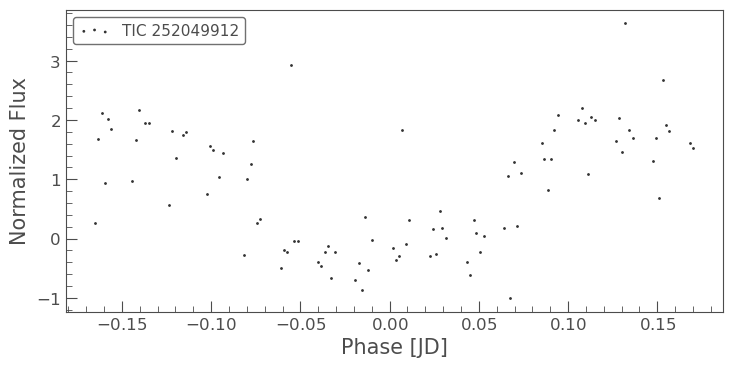

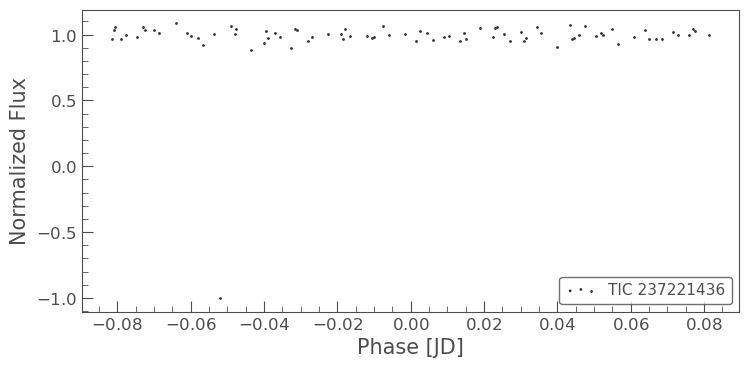

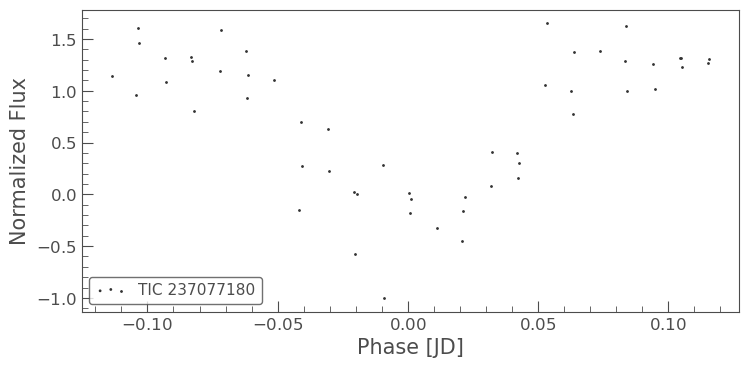

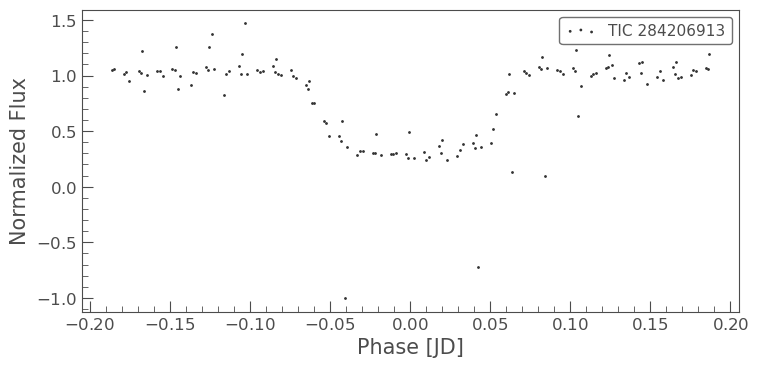

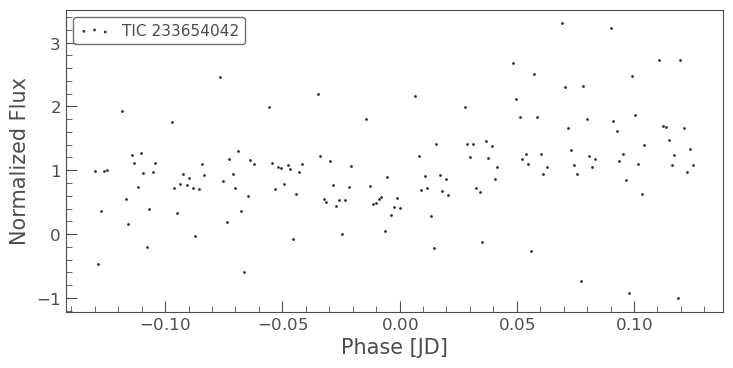

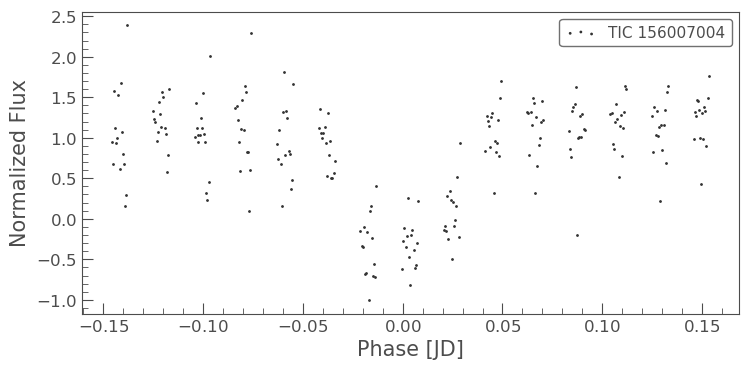

In [11]:
#METHOD 4: refining method 3
#error-catching: only considering the lightcurves where the quality array has int32 values, not str32

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

for x in range(4000, 4020):
    TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
    period = float(rows[x][fields.index("Period (days)")])
    t0 = float(rows[x][fields.index("Epoch (BJD)")])
    duration_hours = float(rows[x][fields.index("Duration (hours)")])
    
    try:
        if(duration_hours < 3.0):
            search_result = lk.search_lightcurve(TOI_name, exptime=120) #if the period is short, choose a shorter cadence for more data
            if(len(search_result) == 0):
                search_result = lk.search_lightcurve(TOI_name, exptime=1800) #if no curves with the given cadence exist, pick a different cadence
                search_result = search_result[1:] #to get rid of the DIAMANTE author
        else:  
            search_result = lk.search_lightcurve(TOI_name, exptime=1800) #searching for curves with a given cadence (i.e. 30 mins)
            search_result = search_result[1:] #to get rid of the DIAMANTE author
            if(len(search_result) == 0):
                search_result = lk.search_lightcurve(TOI_name, exptime=120) #if no curves with the given cadence exist, pick a different cadence

        lcs_raw = search_result.download_all() #downloading all the curves with that cadence
        for item in lcs_raw:
            if(type(item) is None): #double-checking to make sure no NoneType items are in the search result
                del(item)

        lcs = lk.LightCurveCollection(lightcurves=[])
        for item in lcs_raw:
            if(item.quality.dtype == ">i4"): #only considering the lightcurves where the quality array has int32 values, not str32
                lcs.append(item)
        
        lc_raw = lcs.stitch() #stitching the curves together

        lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4) #removes data points if they are sigma standard deviations from the median
        #sigma_upper is for the number of standard deviations above the median to clip

        fractional_duration = (duration_hours / 24.0) / period #calculates the fraction of the period that is taken up by the actual transit of the planet

        if(fractional_duration < 0.02): #if the duration of the transit is short, choose a different simplifying method to avoid deleting too much data
            lc_fold = lc_clean.fold(period, epoch_time=(t0-2457000))
            #skipping a lot of the pre-processing
            phase_mask = (lc_fold.phase > -15*fractional_duration) & (lc_fold.phase < 15.0*fractional_duration) 
            #create a phase mask that takes data inside of 15 times the fractional duration of the transit
            lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
            #again, this curve starts at 1 and dips down

            lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #look down: same process as for the lc_global curve
            lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
            #end result: a curve that goes from a flux of 1 to a flux of -1

            lc_local.scatter(); #plot a scatterplot of the final data

        else:
            temp_fold = lc_clean.fold(period, epoch_time=(t0-2457000)) #doing an initial fold of the lightcurve
            #epoch_time is used in units of BJD, not JD, so we subtract 2457000 from the initial epoch time
            phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5) #a mask is an array with True during transits and False elsewhere
            #creates an np array that has True if the value of the phase of the curve is within 1.5 of the fractional duration of the transit
            #because 0 is the very middle of the planet's transit?? so we are getting an ample window on either side of the transit
            transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])
            #temp_fold.time_original.value[phase_mask]: shorter array with only the length of the number of "True"s in the phase_mask
            #transit_mask: True if the time value from the original unfolded array is a time masked by the phase_mask

            lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask) #flattens the lightcurve; does not remove data that is masked by the transit mask
            lc_fold = lc_flat.fold(period, epoch_time=(t0-2457000)) #folds the new, flattened, cleaner lightcurve

            lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1 #binning: uses interpolation to create a new point every 0.005 time units; returns a curve made of those new points
            #normalize the flux so the curve starts at 1 and dips down
            #subtract 1 so the curve starts at 0 and dips into the negative numbers
            #NOTE: the .normalize() method divides all flux values by the median flux 
            lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1 #divide by the lowest point on the curve so that the curve starts at 0 and dips down to -1
            # multiply by 2 and then add 1 so the curve goes from a flux of 1 to -1

            phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration) 
            #create a phase mask that only takes data inside of 4 times the fractional duration of the transit
            lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
            #again, this curve starts at 1 and dips down

            lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #same process as for the lc_global curve
            lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
            #end result: a curve that goes from a flux of 1 to a flux of -1

            lc_local.scatter(); #plot a scatterplot of the final data
    except:
        print("Error in processing", TOI_name)

Optimized Over-fitting metric: 0.9997772678763294
Optimized Under-fitting metric: 0.9992879265339397
Optimized Alpha: 9.765e+03
Optimized Over-fitting metric: 0.999524012973707
Optimized Under-fitting metric: 0.9986919350161247
Optimized Alpha: 9.585e+03


/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'kspsap_flux_lag', 'kspsap_flux_sml', 'sap_flux', 'kspsap_flux', 'sap_bkg'}
  warnings.warn(


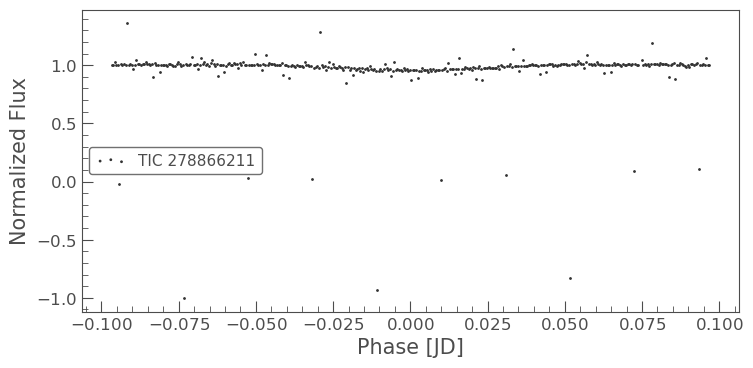

In [6]:
#COTRENDING BASIS VECTORS: METHOD 1
#using method 1 above, but correcting all lightcurves with their cotrending basis vectors before stitching together

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

def cotrendingBasisVectors(lc):
    cbvs = lk.correctors.download_tess_cbvs(sector=lc.sector, camera=lc.camera, ccd=lc.ccd, cbv_type='SingleScale')
    cbvs_interpolated = cbvs.interpolate(lc, extrapolate=False)
    cbv_designmatrix = cbvs_interpolated.to_designmatrix(cbv_indices=np.arange(1,9), name='SingleScale')
    
    cbvcorrector = lk.correctors.CBVCorrector(lc, interpolate_cbvs=True)
    return cbvcorrector.correct(cbv_type=['SingleScale', 'Spike'], cbv_indices=[np.arange(1,9), 'ALL'], ext_dm=cbv_designmatrix)

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

x = 102
TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
period = float(rows[x][fields.index("Period (days)")])
t0 = float(rows[x][fields.index("Epoch (BJD)")])
duration_hours = float(rows[x][fields.index("Duration (hours)")])
    
try:
    search_result = lk.search_lightcurve(TOI_name, exptime=1800) #searching for curves with a given cadence (i.e. 30 mins)
    search_result = search_result[1:] #to get rid of the DIAMANTE author
    if(len(search_result) == 0):
        search_result = lk.search_lightcurve(TOI_name, exptime=120) #if no curves with the given cadence exist, pick a different cadence

    lcs = search_result.download_all() #downloading all the curves with that cadence
    
    for x in range(0, len(lcs)):
        try:
            lcs[x] = cotrendingBasisVectors(lcs[x])
        except:
            lcs[x] = lcs[x]
    
    lc_raw = lcs.stitch() #stitching the curves together

    lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4) #removes data points if they are sigma standard deviations from the median
    #sigma_upper is for the number of standard deviations above the median to clip

    temp_fold = lc_clean.fold(period, epoch_time=(t0-2457000)) #doing an initial fold of the lightcurve
    #epoch_time is used in units of BJD, not JD, so we subtract 2457000 from the initial epoch time
    fractional_duration = (duration_hours / 24.0) / period #calculates the fraction of the period that is taken up by the actual transit of the planet
    phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5) #a mask is an array with True during transits and False elsewhere
    #creates an np array that has True if the value of the phase of the curve is within 1.5 of the fractional duration of the transit
    #because 0 is the very middle of the planet's transit?? so we are getting an ample window on either side of the transit
    transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])
    #temp_fold.time_original.value[phase_mask]: shorter array with only the length of the number of "True"s in the phase_mask
    #transit_mask: True if the time value from the original unfolded array is a time masked by the phase_mask

    lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask) #flattens the lightcurve; does not remove data that is masked by the transit mask
    lc_fold = lc_flat.fold(period, epoch_time=(t0-2457000)) #folds the new, flattened, cleaner lightcurve

    lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1 #binning: uses interpolation to create a new point every 0.005 time units; returns a curve made of those new points
    #normalize the flux so the curve starts at 1 and dips down
    #subtract 1 so the curve starts at 0 and dips into the negative numbers
    #NOTE: the .normalize() method divides all flux values by the median flux 
    lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1 #divide by the lowest point on the curve so that the curve starts at 0 and dips down to -1
    # multiply by 2 and then add 1 so the curve goes from a flux of 1 to -1

    phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration) 
    #create a phase mask that only takes data inside of 4 times the fractional duration of the transit
    lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
    #again, this curve starts at 1 and dips down

    lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #same process as for the lc_global curve
    lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
    #end result: a curve that goes from a flux of 1 to a flux of -1

    lc_local.scatter(); #plot a scatterplot of the final data

except:
    print("Error in processing", TOI_name)

/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invali

Optimized Over-fitting metric: 0.9994292592144215
Optimized Under-fitting metric: 1.0
Optimized Alpha: 9.618e+03


/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anahitasrinivasan/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invali

Optimized Over-fitting metric: 0.9998206754298609
Optimized Under-fitting metric: 0.9999967390892474
Optimized Alpha: 9.576e+03


Extrapolation of CBVs appears to be necessary. Extrapolated values will be filled with zeros. Recommend setting extrapolate=True
Some interpolated (or extrapolated) CBV values have been set to zero
Extrapolation of CBVs appears to be necessary. Extrapolated values will be filled with zeros. Recommend setting extrapolate=True
Some interpolated (or extrapolated) CBV values have been set to zero
Extrapolation of CBVs appears to be necessary. Extrapolated values will be filled with zeros. Recommend setting extrapolate=True
Some interpolated (or extrapolated) CBV values have been set to zero
Extrapolation of CBVs appears to be necessary. Extrapolated values will be filled with zeros. Recommend setting extrapolate=True
Some interpolated (or extrapolated) CBV values have been set to zero
Extrapolation of CBVs appears to be necessary. Extrapolated values will be filled with zeros. Recommend setting extrapolate=True
Some interpolated (or extrapolated) CBV values have been set to zero
Extrapolat

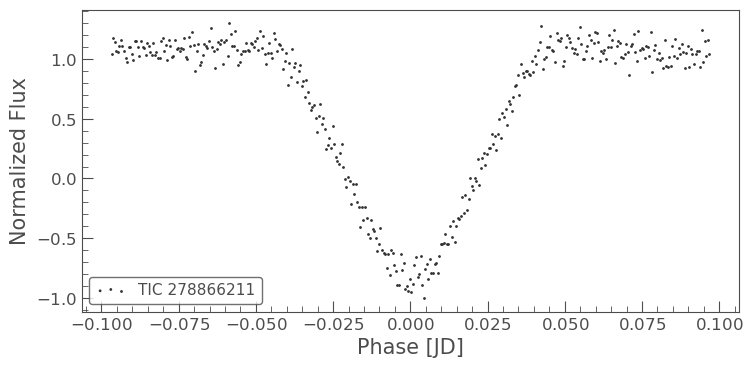

In [7]:
#COTRENDING BASIS VECTORS: METHOD 2
#using method 2 above, but correcting all lightcurves with their cotrending basis vectors before stitching together

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

def cotrendingBasisVectors(lc):
    cbvs = lk.correctors.download_tess_cbvs(sector=lc.sector, camera=lc.camera, ccd=lc.ccd, cbv_type='SingleScale')
    cbvs_interpolated = cbvs.interpolate(lc, extrapolate=False)
    cbv_designmatrix = cbvs_interpolated.to_designmatrix(cbv_indices=np.arange(1,9), name='SingleScale')
    
    cbvcorrector = lk.correctors.CBVCorrector(lc, interpolate_cbvs=True)
    return cbvcorrector.correct(cbv_type=['SingleScale', 'Spike'], cbv_indices=[np.arange(1,9), 'ALL'], ext_dm=cbv_designmatrix)

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

x = 102
TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
period = float(rows[x][fields.index("Period (days)")])
t0 = float(rows[x][fields.index("Epoch (BJD)")])
duration_hours = float(rows[x][fields.index("Duration (hours)")])

try:
    if(duration_hours < 3.0): #if the period is short, choose a shorter cadence for more data
        search_result = lk.search_lightcurve(TOI_name, exptime=120)
    else:  
        search_result = lk.search_lightcurve(TOI_name, exptime=1800) #searching for curves with a given cadence (i.e. 30 mins)
        search_result = search_result[1:] #to get rid of the DIAMANTE author
        if(len(search_result) == 0):
            search_result = lk.search_lightcurve(TOI_name, exptime=120) #if no curves with the given cadence exist, pick a different cadence

    lcs = search_result.download_all() #downloading all the curves with that cadence
    
    for x in range(0, len(lcs)):
        try:
            lcs[x] = cotrendingBasisVectors(lcs[x])
        except:
            lcs[x] = lcs[x]
    
    lc_raw = lcs.stitch() #stitching the curves together

    lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4) #removes data points if they are sigma standard deviations from the median
    #sigma_upper is for the number of standard deviations above the median to clip

    temp_fold = lc_clean.fold(period, epoch_time=(t0-2457000)) #doing an initial fold of the lightcurve
    #epoch_time is used in units of BJD, not JD, so we subtract 2457000 from the initial epoch time
    fractional_duration = (duration_hours / 24.0) / period #calculates the fraction of the period that is taken up by the actual transit of the planet
    phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5) #a mask is an array with True during transits and False elsewhere
    #creates an np array that has True if the value of the phase of the curve is within 1.5 of the fractional duration of the transit
    #because 0 is the very middle of the planet's transit?? so we are getting an ample window on either side of the transit
    transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])
    #temp_fold.time_original.value[phase_mask]: shorter array with only the length of the number of "True"s in the phase_mask
    #transit_mask: True if the time value from the original unfolded array is a time masked by the phase_mask

    lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask) #flattens the lightcurve; does not remove data that is masked by the transit mask
    lc_fold = lc_flat.fold(period, epoch_time=(t0-2457000)) #folds the new, flattened, cleaner lightcurve

    lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1 #binning: uses interpolation to create a new point every 0.005 time units; returns a curve made of those new points
    #normalize the flux so the curve starts at 1 and dips down
    #subtract 1 so the curve starts at 0 and dips into the negative numbers
    #NOTE: the .normalize() method divides all flux values by the median flux 
    lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1 #divide by the lowest point on the curve so that the curve starts at 0 and dips down to -1
    # multiply by 2 and then add 1 so the curve goes from a flux of 1 to -1

    if(fractional_duration < 0.02): #if the duration of the transit is short, take a larger window to see
        phase_mask = (lc_fold.phase > -15*fractional_duration) & (lc_fold.phase < 15.0*fractional_duration) 
    else:
        phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration) 
        #create a phase mask that only takes data inside of 4 times the fractional duration of the transit
    lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
    #again, this curve starts at 1 and dips down

    lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #same process as for the lc_global curve
    lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
    #end result: a curve that goes from a flux of 1 to a flux of -1

    lc_local.scatter(); #plot a scatterplot of the final data
except:
    print("Error in processing", TOI_name)

In [ ]:
#COTRENDING BASIS VECTORS: METHOD 3
#using method 3 above, but correcting all lightcurves with their cotrending basis vectors before stitching together

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

def cotrendingBasisVectors(lc):
    cbvs = lk.correctors.download_tess_cbvs(sector=lc.sector, camera=lc.camera, ccd=lc.ccd, cbv_type='SingleScale')
    cbvs_interpolated = cbvs.interpolate(lc, extrapolate=False)
    cbv_designmatrix = cbvs_interpolated.to_designmatrix(cbv_indices=np.arange(1,9), name='SingleScale')
    
    cbvcorrector = lk.correctors.CBVCorrector(lc, interpolate_cbvs=True)
    return cbvcorrector.correct(cbv_type=['SingleScale', 'Spike'], cbv_indices=[np.arange(1,9), 'ALL'], ext_dm=cbv_designmatrix)

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

x = 119
TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
period = float(rows[x][fields.index("Period (days)")])
t0 = float(rows[x][fields.index("Epoch (BJD)")])
duration_hours = float(rows[x][fields.index("Duration (hours)")])
    
try:
    if(duration_hours < 3.0):
        search_result = lk.search_lightcurve(TOI_name, exptime=120) #if the period is short, choose a shorter cadence for more data
        if(len(search_result) == 0):
            search_result = lk.search_lightcurve(TOI_name, exptime=1800) #if no curves with the given cadence exist, pick a different cadence
            search_result = search_result[1:] #to get rid of the DIAMANTE author
    else:  
        search_result = lk.search_lightcurve(TOI_name, exptime=1800) #searching for curves with a given cadence (i.e. 30 mins)
        search_result = search_result[1:] #to get rid of the DIAMANTE author
        if(len(search_result) == 0):
            search_result = lk.search_lightcurve(TOI_name, exptime=120) #if no curves with the given cadence exist, pick a different cadence

    lcs = search_result.download_all() #downloading all the curves with that cadence
    for item in lcs:
        if(type(item) is None): #double-checking to make sure no NoneType items are in the search result
            del(item)
    
    for x in range(0, len(lcs)):
        try:
            lcs[x] = cotrendingBasisVectors(lcs[x])
        except:
            lcs[x] = lcs[x]
    
    lc_raw = lcs.stitch() #stitching the curves together

    lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4) #removes data points if they are sigma standard deviations from the median
    #sigma_upper is for the number of standard deviations above the median to clip

    fractional_duration = (duration_hours / 24.0) / period #calculates the fraction of the period that is taken up by the actual transit of the planet

    if(fractional_duration < 0.02): #if the duration of the transit is short, choose a different simplifying method to avoid deleting too much data
        lc_fold = lc_clean.fold(period, epoch_time=(t0-2457000))
        #skipping a lot of the pre-processing
        phase_mask = (lc_fold.phase > -15*fractional_duration) & (lc_fold.phase < 15.0*fractional_duration) 
        #create a phase mask that takes data inside of 15 times the fractional duration of the transit
        lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
        #again, this curve starts at 1 and dips down

        lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #look down: same process as for the lc_global curve
        lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
        #end result: a curve that goes from a flux of 1 to a flux of -1

        lc_local.scatter(); #plot a scatterplot of the final data

    else:
        temp_fold = lc_clean.fold(period, epoch_time=(t0-2457000)) #doing an initial fold of the lightcurve
        #epoch_time is used in units of BJD, not JD, so we subtract 2457000 from the initial epoch time
        phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5) #a mask is an array with True during transits and False elsewhere
        #creates an np array that has True if the value of the phase of the curve is within 1.5 of the fractional duration of the transit
        #because 0 is the very middle of the planet's transit?? so we are getting an ample window on either side of the transit
        transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])
        #temp_fold.time_original.value[phase_mask]: shorter array with only the length of the number of "True"s in the phase_mask
        #transit_mask: True if the time value from the original unfolded array is a time masked by the phase_mask

        lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask) #flattens the lightcurve; does not remove data that is masked by the transit mask
        lc_fold = lc_flat.fold(period, epoch_time=(t0-2457000)) #folds the new, flattened, cleaner lightcurve

        lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1 #binning: uses interpolation to create a new point every 0.005 time units; returns a curve made of those new points
        #normalize the flux so the curve starts at 1 and dips down
        #subtract 1 so the curve starts at 0 and dips into the negative numbers
        #NOTE: the .normalize() method divides all flux values by the median flux 
        lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1 #divide by the lowest point on the curve so that the curve starts at 0 and dips down to -1
        # multiply by 2 and then add 1 so the curve goes from a flux of 1 to -1

        phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration) 
        #create a phase mask that only takes data inside of 4 times the fractional duration of the transit
        lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
        #again, this curve starts at 1 and dips down

        lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #same process as for the lc_global curve
        lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
        #end result: a curve that goes from a flux of 1 to a flux of -1

        lc_local.scatter(); #plot a scatterplot of the final data
except:
    print("Error in processing", TOI_name)

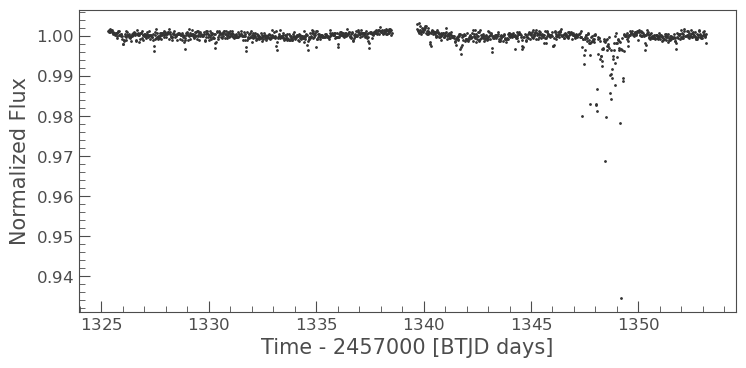

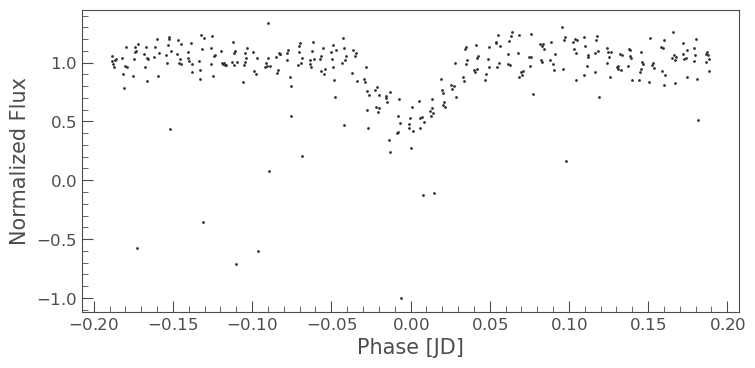

In [3]:
#PIXEL-LEVEL DECORRELATION: METHOD 1
#downloading target pixel files, not lightcurves
#using PLD to convert each TPF into a lightcurve, then stitching those curves together

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

x = 0
TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
period = float(rows[x][fields.index("Period (days)")])
t0 = float(rows[x][fields.index("Epoch (BJD)")])
duration_hours = float(rows[x][fields.index("Duration (hours)")])

search_result = lk.search_tesscut(TOI_name) #searching for TESS cuts, not lightcruves
tpf_collection = lk.TargetPixelFileCollection(tpfs=[]) #creating a container for the Target Pixel Files
counter = 0

for item in search_result:
    if item.exptime.value > 1400.0:
        tpf = search_result[counter].download(cutout_size=12);
        tpf_collection.append(tpf) #only keeping the items in the search result with a large exposure time
    counter += 1

lcs = lk.LightCurveCollection(lightcurves=[]) #creating a container for the newly created lightcurves

for tpf in tpf_collection:
    pld = lk.correctors.PLDCorrector(tpf)
    corrected_lc = pld.correct(sparse=True) #creating a PLD-corrected lightcurve for each target pixel file
    lcs.append(corrected_lc) #adding the lightcurves to the container

lc_raw = lcs.stitch() #stitching together all the lightcurves
lc_raw.scatter();

lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4) #removes data points if they are sigma standard deviations from the median
#sigma_upper is for the number of standard deviations above the median to clip

fractional_duration = (duration_hours / 24.0) / period #calculates the fraction of the period that is taken up by the actual transit of the planet
lc_fold = lc_clean.fold(period, epoch_time=(t0-2457000))
#skipping a lot of the pre-processing
phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration) 
#create a phase mask that takes data inside of 15 times the fractional duration of the transit
lc_zoom = lc_fold[phase_mask] #create a new folded lightcurve, made only of the data where the phase_mask array has value True
#again, this curve starts at 1 and dips down

lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1 #look down: same process as for the lc_global curve
lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1 #nanmin: minimum of an array, ignoring any NaNs
#end result: a curve that goes from a flux of 1 to a flux of -1

lc_local.scatter(); #plot a scatterplot of the final data

In [ ]:
#NEW METHOD - IMPROVED
#change method based on duration_hours and fractional_duration
#change time-bin size and size of the phase mask
#catch AttributeError and TimeDivisionError

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

data = "data.csv"
fields = []
rows = []

with open(data, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)

for x in range(122, 123):
    try:
        TOI_name = "TIC " + rows[x][fields.index("TIC ID")]
        period = float(rows[x][fields.index("Period (days)")])
        t0 = float(rows[x][fields.index("Epoch (BJD)")])
        duration_hours = float(rows[x][fields.index("Duration (hours)")])
        fractional_duration = (duration_hours / 24.0) / period

        if(duration_hours < 3.0):
            
            if(fractional_duration < 0.004):
                search_result_1 = lk.search_lightcurve(TOI_name, author="SPOC", exptime=120)
                if(len(search_result_1) == 0):
                    search_result_1 = lk.search_lightcurve(TOI_name, author="TESS-SPOC", exptime=1800)
                    if(len(search_result_1) == 0):
                        search_result_1 = lk.search_lightcurve(TOI_name, author="QLP", exptime=1800)

                lcs_1 = search_result_1.download_all() 
                lc_raw_1 = lcs_1.stitch() 

                lc_clean_1 = lc_raw_1.remove_outliers(sigma=20, sigma_upper=4) 

                temp_fold_1 = lc_clean_1.fold(period, epoch_time=(t0-2457000))

                fractional_duration = (duration_hours / 24.0) / period

                phase_mask = (temp_fold_1.phase > -300*fractional_duration) & (temp_fold_1.phase < 300.0*fractional_duration) #USED TO BE 15 - may need to change back
                lc_zoom_1 = temp_fold_1[phase_mask]

                lc_local_1 = lc_zoom_1.bin(time_bin_size=0.0008).normalize() - 1 #USED TO BE 0.0044 - may need to change back
                lc_local_1.scatter();
            
            if(fractional_duration < 0.01):
                search_result_1 = lk.search_lightcurve(TOI_name, author="SPOC", exptime=120)
                if(len(search_result_1) == 0):
                    search_result_1 = lk.search_lightcurve(TOI_name, author="TESS-SPOC", exptime=1800)
                    if(len(search_result_1) == 0):
                        search_result_1 = lk.search_lightcurve(TOI_name, author="QLP", exptime=1800)

                lcs_1 = search_result_1.download_all() 
                lc_raw_1 = lcs_1.stitch() 

                lc_clean_1 = lc_raw_1.remove_outliers(sigma=20, sigma_upper=4) 

                temp_fold_1 = lc_clean_1.fold(period, epoch_time=(t0-2457000))

                fractional_duration = (duration_hours / 24.0) / period

                phase_mask = (temp_fold_1.phase > -15*fractional_duration) & (temp_fold_1.phase < 15.0*fractional_duration) #USED TO BE 15 - may need to change back
                lc_zoom_1 = temp_fold_1[phase_mask]

                lc_local_1 = lc_zoom_1.bin(time_bin_size=0.0044).normalize() - 1 #USED TO BE 0.0044 - may need to change back
                lc_local_1.scatter();
            
            elif(fractional_duration < 0.04):
                search_result_1 = lk.search_lightcurve(TOI_name, author="SPOC", exptime=120)
                if(len(search_result_1) == 0):
                    search_result_1 = lk.search_lightcurve(TOI_name, author="TESS-SPOC", exptime=1800)
                    if(len(search_result_1) == 0):
                        search_result_1 = lk.search_lightcurve(TOI_name, author="QLP", exptime=1800)

                lcs_1 = search_result_1.download_all() 
                lc_raw_1 = lcs_1.stitch() 

                lc_clean_1 = lc_raw_1.remove_outliers(sigma=20, sigma_upper=4) 

                temp_fold_1 = lc_clean_1.fold(period, epoch_time=(t0-2457000))

                fractional_duration = (duration_hours / 24.0) / period

                phase_mask = (temp_fold_1.phase > -4*fractional_duration) & (temp_fold_1.phase < 4.0*fractional_duration) 
                lc_zoom_1 = temp_fold_1[phase_mask]

                lc_local_1 = lc_zoom_1.bin(time_bin_size=0.0008).normalize() - 1 
                lc_local_1.scatter();
            
            else:
                search_result_2 = lk.search_lightcurve(TOI_name, author="TESS-SPOC", exptime=1800)
                if(len(search_result_2) == 0):
                    search_result_2 = lk.search_lightcurve(TOI_name, author="SPOC", exptime=120)
                    if(len(search_result_2) == 0):
                        search_result_2 = lk.search_lightcurve(TOI_name, author="QLP", exptime=1800)

                lcs_2 = search_result_2.download_all() 
                lc_raw_2 = lcs_2.stitch() 

                lc_clean_2 = lc_raw_2.remove_outliers(sigma=20, sigma_upper=4) 

                temp_fold_2 = lc_clean_2.fold(period, epoch_time=(t0-2457000))

                fractional_duration = (duration_hours / 24.0) / period

                phase_mask_2 = np.abs(temp_fold_2.phase.value) < (fractional_duration * 1.5)
                transit_mask_2 = np.in1d(lc_clean_2.time.value, temp_fold_2.time_original.value[phase_mask_2])

                lc_flat_2 = lc_clean_2.flatten(mask=transit_mask_2)

                lc_fold_2 = lc_flat_2.fold(period, epoch_time=(t0-2457000))

                lc_global_2 = lc_fold_2.bin(time_bin_size=0.0008).normalize() - 1

                '''lc_global_2 = (lc_global_2 / np.abs(lc_global_2.flux.min()) ) * 2.0 + 1
                lc_global_2.scatter();''' #comment out

                phase_mask = (lc_fold_2.phase > -15*fractional_duration) & (lc_fold_2.phase < 15.0*fractional_duration) 
                lc_zoom_2 = lc_fold_2[phase_mask]

                lc_local_2 = lc_zoom_2.bin(time_bin_size=0.0008).normalize() - 1 
                lc_local_2 = (lc_local_2 / np.abs(np.nanmin(lc_local_2.flux)) ) * 2.0 + 1 

                lc_local_2.scatter();
    
        elif(duration_hours < 5.0):
            search_result_1 = lk.search_lightcurve(TOI_name, author="SPOC", exptime=120) #SHOULD BE SPOC AND 120
            if(len(search_result_1) == 0):
                search_result_1 = lk.search_lightcurve(TOI_name, author="TESS-SPOC", exptime=1800)
                if(len(search_result_1) == 0):
                    search_result_1 = lk.search_lightcurve(TOI_name, author="QLP", exptime=1800)

            lcs_1 = search_result_1.download_all() 
            lc_raw_1 = lcs_1.stitch() 

            lc_clean_1 = lc_raw_1.remove_outliers(sigma=20, sigma_upper=4) 

            temp_fold_1 = lc_clean_1.fold(period, epoch_time=(t0-2457000))

            fractional_duration = (duration_hours / 24.0) / period

            phase_mask = (temp_fold_1.phase > -25*fractional_duration) & (temp_fold_1.phase < 25.0*fractional_duration) 
            lc_zoom_1 = temp_fold_1[phase_mask]

            lc_local_1 = lc_zoom_1.bin(time_bin_size=0.0008).normalize() - 1 
            lc_local_1.scatter();
        
        else:
            if(fractional_duration < 0.02):
                search_result_1 = lk.search_lightcurve(TOI_name, author="TESS-SPOC", exptime=1800) #Should be SPOC and 120
                if(len(search_result_1) == 0):
                    search_result_1 = lk.search_lightcurve(TOI_name, author="SPOC", exptime=120)
                    if(len(search_result_1) == 0):
                        search_result_1 = lk.search_lightcurve(TOI_name, author="QLP", exptime=1800)

                lcs_1 = search_result_1.download_all() 
                lc_raw_1 = lcs_1.stitch() 

                lc_clean_1 = lc_raw_1.remove_outliers(sigma=20, sigma_upper=4) 

                temp_fold_1 = lc_clean_1.fold(period, epoch_time=(t0-2457000))

                fractional_duration = (duration_hours / 24.0) / period

                phase_mask = (temp_fold_1.phase > -300*fractional_duration) & (temp_fold_1.phase < 300.0*fractional_duration) #USED TO BE 300 - may need to change
                lc_zoom_1 = temp_fold_1[phase_mask]

                lc_local_1 = lc_zoom_1.bin(time_bin_size=0.0008).normalize() - 1 
                lc_local_1.scatter();
            else:
                search_result_2 = lk.search_lightcurve(TOI_name, author="TESS-SPOC", exptime=1800)
                if(len(search_result_2) == 0):
                    search_result_2 = lk.search_lightcurve(TOI_name, author="SPOC", exptime=120)
                    if(len(search_result_2) == 0):
                        search_result_1 = lk.search_lightcurve(TOI_name, author="QLP", exptime=1800)

                lcs_2 = search_result_2.download_all() 
                lc_raw_2 = lcs_2.stitch() 

                lc_clean_2 = lc_raw_2.remove_outliers(sigma=20, sigma_upper=4) 

                temp_fold_2 = lc_clean_2.fold(period, epoch_time=(t0-2457000))

                fractional_duration = (duration_hours / 24.0) / period

                phase_mask_2 = np.abs(temp_fold_2.phase.value) < (fractional_duration * 1.5)
                transit_mask_2 = np.in1d(lc_clean_2.time.value, temp_fold_2.time_original.value[phase_mask_2])

                lc_flat_2 = lc_clean_2.flatten(mask=transit_mask_2)

                lc_fold_2 = lc_flat_2.fold(period, epoch_time=(t0-2457000))

                lc_global_2 = lc_fold_2.bin(time_bin_size=0.0008).normalize() - 1

                '''lc_global_2 = (lc_global_2 / np.abs(lc_global_2.flux.min()) ) * 2.0 + 1
                lc_global_2.scatter();''' #comment out

                phase_mask = (lc_fold_2.phase > -15*fractional_duration) & (lc_fold_2.phase < 15.0*fractional_duration) 
                lc_zoom_2 = lc_fold_2[phase_mask]

                lc_local_2 = lc_zoom_2.bin(time_bin_size=0.0008).normalize() - 1 
                lc_local_2 = (lc_local_2 / np.abs(np.nanmin(lc_local_2.flux)) ) * 2.0 + 1 

                lc_local_2.scatter();
    except AttributeError:
        print("AttributeError occured with", TOI_name, "item", str(x))
    except ZeroDivisionError:
        print("ZeroDivisionError occured with", TOI_name, "item", str(x))
    except:
        print("An error occured with", TOI_name, "item", str(x))